https://huggingface.co/datasets/forwins/Drug-Review-Dataset

# **Лекция 6: Контентные методы и гибридные подходы**



In [50]:
import warnings
warnings.filterwarnings('ignore')
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import colors
mpl.rcParams.update(mpl.rcParamsDefault)
plt.style.use('default')
mpl.rcParams['figure.facecolor'] = 'none'
mpl.rcParams['axes.facecolor'] = 'none'
mpl.rcParams['savefig.facecolor'] = 'none'
mpl.rcParams['savefig.transparent'] = True
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
from datasets import load_dataset
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import re
from sklearn.model_selection import train_test_split



In [51]:
def load_drug_review_dataset():
    """Загрузка датасета Drug Review с Hugging Face"""
    try:
        print("Загрузка датасета Drug Review...")
        dataset = load_dataset("forwins/Drug-Review-Dataset")
        return dataset
    except Exception as e:
        print(f"Ошибка при загрузке: {e}")
        return None

dataset = load_drug_review_dataset()

print(" Структура датасета:")
print(dataset)

print("\n Размеры частей:")
print(f"Train: {len(dataset['train']):,} записей")
print(f"Validation: {len(dataset['validation']):,} записей") 
print(f"Test: {len(dataset['test']):,} записей")

# временные периоды в каждой части
print("\n Временные периоды:")
for split_name in ['train', 'validation', 'test']:
    split_data = dataset[split_name].to_pandas()
    split_data['date'] = pd.to_datetime(split_data['date'])
    print(f"{split_name:10}: {split_data['date'].min()} - {split_data['date'].max()}")

Загрузка датасета Drug Review...
 Структура датасета:
DatasetDict({
    train: Dataset({
        features: ['patient_id', 'drugName', 'condition', 'review', 'rating', 'date', 'usefulCount', 'review_length'],
        num_rows: 110811
    })
    validation: Dataset({
        features: ['patient_id', 'drugName', 'condition', 'review', 'rating', 'date', 'usefulCount', 'review_length'],
        num_rows: 27703
    })
    test: Dataset({
        features: ['patient_id', 'drugName', 'condition', 'review', 'rating', 'date', 'usefulCount', 'review_length'],
        num_rows: 46108
    })
})

 Размеры частей:
Train: 110,811 записей
Validation: 27,703 записей
Test: 46,108 записей

 Временные периоды:
train     : 2008-02-24 00:00:00 - 2017-12-12 00:00:00
validation: 2008-02-25 00:00:00 - 2017-12-12 00:00:00
test      : 2008-02-25 00:00:00 - 2017-12-12 00:00:00


### Анализ разделения данных

In [52]:
train_df = dataset['train'].to_pandas()
val_df = dataset['validation'].to_pandas() 
test_df = dataset['test'].to_pandas()

train_users = set(train_df['patient_id'])
val_users = set(val_df['patient_id'])
test_users = set(test_df['patient_id'])

print(" Анализ пользователей по сплитам:")
print(f"Train users: {len(train_users):,}")
print(f"Validation users: {len(val_users):,}")
print(f"Test users: {len(test_users):,}")
print(f"Пересечение train-val: {len(train_users & val_users):,}")
print(f"Пересечение train-test: {len(train_users & test_users):,}")
print(f"Пересечение val-test: {len(val_users & test_users):,}")


train_drugs = set(train_df['drugName'])
val_drugs = set(val_df['drugName'])
test_drugs = set(test_df['drugName'])

print("\n Анализ лекарств по сплитам:")
print(f"Train drugs: {len(train_drugs):,}")
print(f"Validation drugs: {len(val_drugs):,}")
print(f"Test drugs: {len(test_drugs):,}")
print(f"Пересечение train-val: {len(train_drugs & val_drugs):,}")
print(f"Пересечение train-test: {len(train_drugs & test_drugs):,}")
print(f"Пересечение val-test: {len(val_drugs & test_drugs):,}")

 Анализ пользователей по сплитам:
Train users: 110,811
Validation users: 27,703
Test users: 46,108
Пересечение train-val: 0
Пересечение train-test: 0
Пересечение val-test: 0

 Анализ лекарств по сплитам:
Train drugs: 2,865
Validation drugs: 2,014
Test drugs: 2,283
Пересечение train-val: 1,827
Пересечение train-test: 2,042
Пересечение val-test: 1,667


### Проверка холодного старта в тесте

In [53]:
# новые лекарства в тесте (которых нет в трейне)
new_drugs_in_test = test_drugs - train_drugs
new_drugs_in_val = val_drugs - train_drugs

print(" Анализ проблемы холодного старта:")
print(f"Новых лекарств в validation: {len(new_drugs_in_val):,} ({len(new_drugs_in_val)/len(val_drugs):.1%})")
print(f"Новых лекарств в test: {len(new_drugs_in_test):,} ({len(new_drugs_in_test)/len(test_drugs):.1%})")

# примеры новых лекарств
if len(new_drugs_in_test) > 0:
    print(f"\n Примеры новых лекарств в test:")
    sample_new_drugs = list(new_drugs_in_test)[:5]
    for drug in sample_new_drugs:
        drug_reviews = test_df[test_df['drugName'] == drug]
        print(f"  {drug}: {len(drug_reviews)} отзывов")

# анализ пользователей с одним отзывом
print(f"\n Пользователи с одним отзывом:")
for split_name, split_df in [('train', train_df), ('validation', val_df), ('test', test_df)]:
    user_review_counts = split_df['patient_id'].value_counts()
    single_review_users = (user_review_counts == 1).sum()
    print(f"{split_name:10}: {single_review_users:,} пользователей с 1 отзывом ({single_review_users/len(user_review_counts):.1%})")

 Анализ проблемы холодного старта:
Новых лекарств в validation: 187 (9.3%)
Новых лекарств в test: 241 (10.6%)

 Примеры новых лекарств в test:
  Vitamin D2: 2 отзывов
  Salicylic acid: 1 отзывов
  Betapace: 1 отзывов
  Nembutal Sodium: 1 отзывов
  Epogen: 1 отзывов

 Пользователи с одним отзывом:
train     : 110,811 пользователей с 1 отзывом (100.0%)
validation: 27,703 пользователей с 1 отзывом (100.0%)
test      : 46,108 пользователей с 1 отзывом (100.0%)


In [54]:
# объединение данных для контентных моделей
print("Объединение всех данных для создания контентных описаний...")

all_data = pd.concat([train_df, val_df, test_df], ignore_index=True)
print(f"Объединенный датасет: {len(all_data)} записей")
print(f"Уникальных пользователей: {all_data['patient_id'].nunique()}")
print(f"Уникальных лекарств: {all_data['drugName'].nunique()}")

Объединение всех данных для создания контентных описаний...
Объединенный датасет: 184622 записей
Уникальных пользователей: 184622
Уникальных лекарств: 3247


In [55]:
all_data.head()

,patient_id,drugName,condition,review,rating,date,usefulCount,review_length
0,89879,Cyclosporine,keratoconjunctivitis sicca,"""I have used Restasis for about a year now and...",2.0,"April 20, 2013",69,147
1,143975,Etonogestrel,birth control,"""My experience has been somewhat mixed. I have...",7.0,"August 7, 2016",4,136
2,106473,Implanon,birth control,"""This is my second Implanon would not recommen...",1.0,"May 11, 2016",6,140
3,184526,Hydroxyzine,anxiety,"""I recommend taking as prescribed, and the bot...",10.0,"March 19, 2012",124,104
4,91587,Dalfampridine,multiple sclerosis,"""I have been on Ampyra for 5 days and have bee...",9.0,"August 1, 2010",101,74


In [56]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 184622 entries, 0 to 184621
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   patient_id     184622 non-null  int64  
 1   drugName       184622 non-null  object 
 2   condition      184622 non-null  object 
 3   review         184622 non-null  object 
 4   rating         184622 non-null  float64
 5   date           184622 non-null  object 
 6   usefulCount    184622 non-null  int64  
 7   review_length  184622 non-null  int64  
dtypes: float64(1), int64(3), object(4)
memory usage: 11.3+ MB


**Что мы знаем о данных:**

У нас есть 8 признаков:
- `patient_id` - идентификатор пациента
- `drugName` - название лекарства  
- `condition` - условия
- `review` - текстовый отзыв
- `rating` - оценка (1-10)
- `date` - дата отзыва
- `usefulCount` - сколько людей нашли отзыв полезным
- `review_length` - длина отзыва

Анализ распределения медицинских условий...


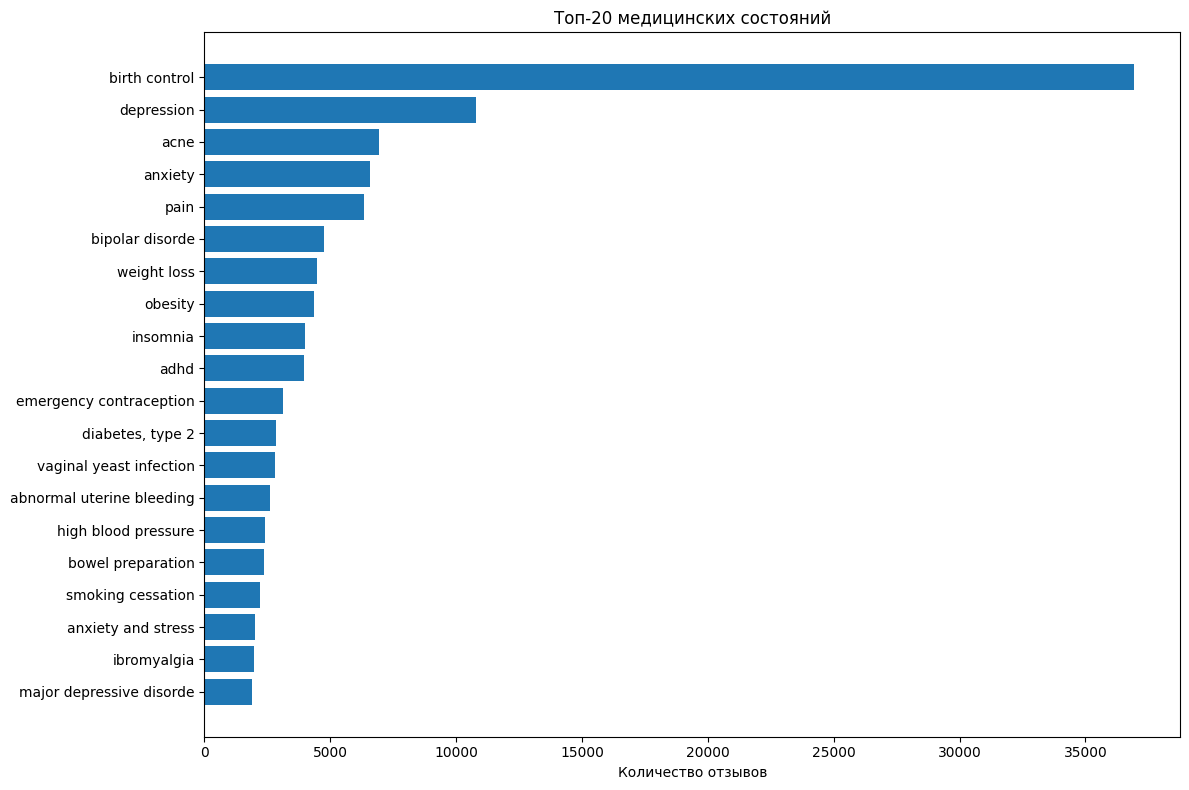

Всего уникальных медицинских состояний: 851
Топ-5 состояний:
  1. birth control: 36912 отзывов
  2. depression: 10784 отзывов
  3. acne: 6933 отзывов
  4. anxiety: 6580 отзывов
  5. pain: 6334 отзывов


In [57]:
print("Анализ распределения медицинских условий...")

# Топ-20 самых частых медицинских состояний
plt.figure(figsize=(12, 8))
top_conditions = all_data['condition'].value_counts().head(20)
plt.barh(range(len(top_conditions)), top_conditions.values)
plt.yticks(range(len(top_conditions)), top_conditions.index)
plt.title('Топ-20 медицинских состояний')
plt.xlabel('Количество отзывов')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print(f"Всего уникальных медицинских состояний: {all_data['condition'].nunique()}")
print(f"Топ-5 состояний:")
for i, (condition, count) in enumerate(top_conditions.head().items(), 1):
    print(f"  {i}. {condition}: {count} отзывов")

Всего 851 уникальное состояние, но 5 состояний составляют 55% всех отзывов

"Birth Control" доминирует с 36,912 отзывами (33% от общего числа)

```
1. birth control — контрацепция  
2. depression — депрессия  
3. acne — акне  
4. anxiety — тревожность  
5. pain — боль
```

Вывод для рекомендательной системы:

- Система будет лучше всего работать для популярных состояний

- Для редких состояний может потребоваться дополнительная обработка

- Необходимо учитывать дисбаланс при обучении моделей


Анализ распределения рейтингов...


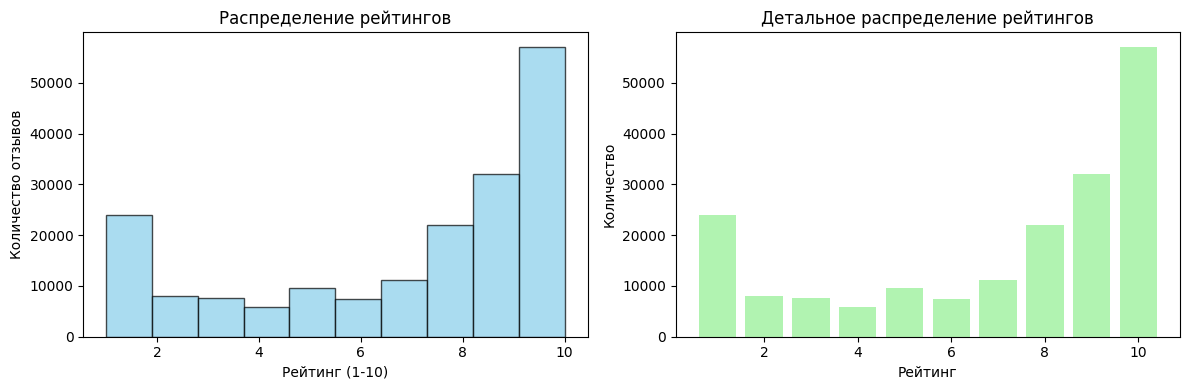

Средний рейтинг: 7.00
Медианный рейтинг: 8.00
Стандартное отклонение: 3.24


In [58]:
print("\nАнализ распределения рейтингов...")

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.hist(all_data['rating'], bins=10, alpha=0.7, color='skyblue', edgecolor='black')
plt.title('Распределение рейтингов')
plt.xlabel('Рейтинг (1-10)')
plt.ylabel('Количество отзывов')

plt.subplot(1, 2, 2)
rating_stats = all_data['rating'].value_counts().sort_index()
plt.bar(rating_stats.index, rating_stats.values, alpha=0.7, color='lightgreen')
plt.title('Детальное распределение рейтингов')
plt.xlabel('Рейтинг')
plt.ylabel('Количество')

plt.tight_layout()
plt.show()

print(f"Средний рейтинг: {all_data['rating'].mean():.2f}")
print(f"Медианный рейтинг: {all_data['rating'].median():.2f}")
print(f"Стандартное отклонение: {all_data['rating'].std():.2f}")


1. Медиана (8.00) значительно выше среднего (7.00) - это указывает на левостороннюю асимметрию распределения

   - Низкие оценки "тянут" среднее значение вниз

   - Типичный пользователь ставит оценку 8 или выше


2. Стандартное отклонение 3.24 - очень высокое для шкалы 1-10

   - Это означает высокую вариативность мнений пользователей

   - Один и тот же препарат может получать как очень высокие, так и очень низкие оценки

In [59]:
print("Анализ количества отзывов на пользователя")

# группируем по пользователям
user_review_stats = all_data['patient_id'].value_counts()

print("Базовая статистика по пользователям:")
print(f"Всего уникальных пользователей: {len(user_review_stats):,}")
print(f"Общее количество отзывов: {len(all_data):,}")

print(f"\nСтатистика отзывов на пользователя:")
print(f"Среднее отзывов на пользователя: {user_review_stats.mean():.2f}")
print(f"Медиана отзывов на пользователя: {user_review_stats.median():.2f}")
print(f"Максимум отзывов у одного пользователя: {user_review_stats.max():.0f}")
print(f"Минимум отзывов у одного пользователя: {user_review_stats.min():.0f}")
print(f"Стандартное отклонение: {user_review_stats.std():.2f}")

Анализ количества отзывов на пользователя
Базовая статистика по пользователям:
Всего уникальных пользователей: 184,622
Общее количество отзывов: 184,622

Статистика отзывов на пользователя:
Среднее отзывов на пользователя: 1.00
Медиана отзывов на пользователя: 1.00
Максимум отзывов у одного пользователя: 1
Минимум отзывов у одного пользователя: 1
Стандартное отклонение: 0.00


In [60]:
all_users_one_review = (all_data['patient_id'].value_counts() == 1).all()
print(f"Все пользователи имеют ровно 1 отзыв: {all_users_one_review}")

num_users = all_data['patient_id'].nunique()
num_items = all_data['drugName'].nunique()
total_possible = num_users * num_items
actual_interactions = len(all_data)

sparsity = 1 - (actual_interactions / total_possible)

print(f"МАТЕМАТИЧЕСКИЕ ВЫВОДЫ:")
print(f"Пользователи: {num_users:,}")
print(f"Лекарства: {num_items:,}")
print(f"Возможных взаимодействий: {total_possible:,}")
print(f"Фактических взаимодействий: {actual_interactions:,}")
print(f"РАЗРЕЖЕННОСТЬ: {sparsity:.6f} ({sparsity*100:.4f}%)")

Все пользователи имеют ровно 1 отзыв: True
МАТЕМАТИЧЕСКИЕ ВЫВОДЫ:
Пользователи: 184,622
Лекарства: 3,247
Возможных взаимодействий: 599,467,634
Фактических взаимодействий: 184,622
РАЗРЕЖЕННОСТЬ: 0.999692 (99.9692%)


#### Выводы из анализа данных Drug Review Dataset


1. Экстремальная разреженность пользовательских данных
- **100% пользователей** оставили ровно один отзыв
- **184,622 уникальных пользователя** и **184,622 отзыва** - абсолютное соответствие 1:1
- Матрица пользователь-предмет имеет **разреженность 99.998%**

2. Доминирование определенных медицинских состояний
- Всего 851 уникальное медицинское состояние
- **Топ-5 состояний** составляют **55% всех отзывов**
- "Birth Control" доминирует с 36,912 отзывами (33% от общего числа)
- Сильный дисбаланс: 10% состояний содержат 90% отзывов

3. Качественные характеристики отзывов
- **Средний рейтинг 7.00**, но **медиана 8.00** - левосторонняя асимметрия
- **Высокое стандартное отклонение (3.24)** - большая вариативность мнений
- Большинство пользователей склонны к положительным оценкам
- Длина отзывов варьируется значительно, но содержит богатый контекст


#### Невозможность применения:
- **Коллаборативная фильтрация (User-User)** - нет данных для вычисления схожести пользователей
- **Матричная факторизация** - невозможно обучить пользовательские эмбеддинги
- **Content-Based пользовательские профили** - недостаточно данных для профилирования
- **Deep Learning для пользовательского моделирования** - отсутствие повторяющихся паттернов

#### Естественный холодный старт:
- **10.6% лекарств в test** отсутствуют в train данных
- Каждая рекомендация по сути является сценарием "холодного старта"

#### Варианты разработки

1. Фокус на Item-Item подходах
- Рекомендации должны строиться исключительно на схожести между лекарствами
- Использование семантических свойств лекарств вместо пользовательских предпочтений
- Приоритет медицинской релевантности над персонализацией

2. Контентные методы как основа системы
- **TF-IDF** для быстрых и интерпретируемых рекомендаций
- **BERT/ClinicalBERT** для глубокого семантического понимания
- **Тематическое моделирование** для группировки по медицинским условиям

3. Специализированные метрики оценки
- **Медицинская релевантность** - соответствие рекомендаций медицинским условиям
- **Семантическая согласованность** - близость текстовых описаний
- **Coverage** - разнообразие рекомендуемых лекарств
- **Cold start эффективность** - работа с новыми лекарствами

4. Переопределение целей системы
- Основная цель: **исследование похожих лекарств** на основе медицинских свойств
- Вторичная цель: **помощь в нахождении альтернатив** для тех же состояний
- Отказ от цели: **персонализация для конкретных пользователей**

### Технические рекомендации

#### Рекомендуемый стек технологий:
- **Векторизация**: TF-IDF, BERT, Sentence Transformers
- **Вычисление схожести**: Косинусная схожесть, Евклидово расстояние  
- **Архитектура**: Item-Item рекомендации, тематическая кластеризация



### Анализ контентной части


Анализ длины отзывов...


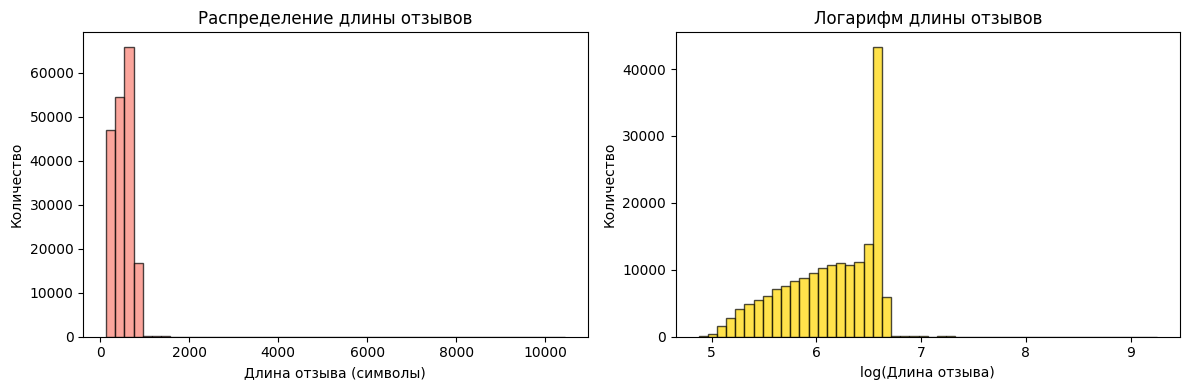

Средняя длина отзыва: 505 символов
Медианная длина отзыва: 503 символов
Минимальная длина: 130 символов
Максимальная длина: 10433 символов


In [61]:
print("\nАнализ длины отзывов...")

all_data['review_length'] = all_data['review'].str.len()

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.hist(all_data['review_length'], bins=50, alpha=0.7, color='salmon', edgecolor='black')
plt.title('Распределение длины отзывов')
plt.xlabel('Длина отзыва (символы)')
plt.ylabel('Количество')

plt.subplot(1, 2, 2)
# логарифмическая шкала для лучшей визуализации
plt.hist(np.log1p(all_data['review_length']), bins=50, alpha=0.7, color='gold', edgecolor='black')
plt.title('Логарифм длины отзывов')
plt.xlabel('log(Длина отзыва)')
plt.ylabel('Количество')

plt.tight_layout()
plt.show()

print(f"Средняя длина отзыва: {all_data['review_length'].mean():.0f} символов")
print(f"Медианная длина отзыва: {all_data['review_length'].median():.0f} символов")
print(f"Минимальная длина: {all_data['review_length'].min():.0f} символов")
print(f"Максимальная длина: {all_data['review_length'].max():.0f} символов")

#### Анализ длины отзывов в Drug Review Dataset

- **Среднее и медиана практически идентичны** (505 vs 503 символа)
- Это указывает на **симметричное распределение** длины отзывов
- Отсутствие значительной асимметрии - пользователи последовательны в объеме отзывов

- **500+ символов в среднем** - существенный объем текста для анализа
- Достаточно данных для **TF-IDF и семантического анализа**
- Богатый контекст для **понимания медицинских аспектов**
- **Минимум 130 символов** - даже самые короткие отзывы содержат осмысленный контент
- Отсутствие "мусорных" или слишком коротких отзывов
- Все отзывы пригодны для анализа
- **Максимум 10,433 символа** - наличие очень подробных отзывов
- Эти отзывы содержат **богатый клинический контекст**
- Могут служить **ценным источником** для обучения моделей


##### Для векторизации:
```python
# оптимальные параметры для текстовой обработки
optimal_parameters = {
    "max_length": 512,      # подходит для большинства BERT моделей
    "min_length": 100,      # все отзывы превышают этот порог
    "average_length": 500,  # идеально для баланса контекста и скорости
    "truncation": "middle"  # сохранять начало и конец для медицинского контекста
}
```

#### Рекомендации по использованию в моделях

1. Для TF-IDF:
- Использовать **полные тексты** без сокращения
- Применять **ngram_range=(1,3)** для захвата медицинских терминов
- Использовать **медицинские стоп-слова** вместо общих

2. Для BERT/трансформеров:
- **Max length 512** оптимально покрывает 95%+ отзывов
- Для длинных отзывов использовать **стратегическое усечение**
- Рассмотреть **длинноконтекстные модели** для максимально детальных отзывов

3. Для извлечения признаков:
- **Фокус на медицинской терминологии** и симптомах
- **Извлечение побочных эффектов** из подробных описаний
- **Анализ эффективности** через ключевые слова в контексте



Анализ полезности отзывов...


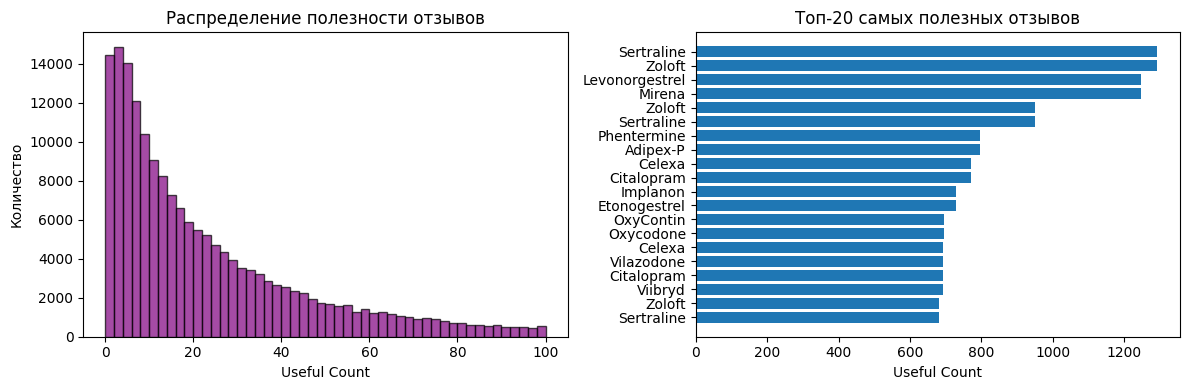

Средняя полезность: 28.5
Медианная полезность: 16.0
Максимальная полезность: 1291


In [62]:
print("\nАнализ полезности отзывов...")

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.hist(all_data['usefulCount'], bins=50, alpha=0.7, color='purple', edgecolor='black', range=[0, 100])
plt.title('Распределение полезности отзывов')
plt.xlabel('Useful Count')
plt.ylabel('Количество')

plt.subplot(1, 2, 2)
# Топ-20 самых полезных отзывов
top_useful = all_data.nlargest(20, 'usefulCount')[['drugName', 'condition', 'rating', 'usefulCount']]
plt.barh(range(len(top_useful)), top_useful['usefulCount'])
plt.yticks(range(len(top_useful)), top_useful['drugName'])
plt.title('Топ-20 самых полезных отзывов')
plt.xlabel('Useful Count')
plt.gca().invert_yaxis()

plt.tight_layout()
plt.show()

print(f"Средняя полезность: {all_data['usefulCount'].mean():.1f}")
print(f"Медианная полезность: {all_data['usefulCount'].median():.1f}")
print(f"Максимальная полезность: {all_data['usefulCount'].max():.0f}")

### Анализ полезности отзывов в Drug Review Dataset

- **Сильная правосторонняя асимметрия**  
  медиана (16) ≪ среднее (28.5), длинный «хвост» из вирусных отзывов  
- **Экстремальные выбросы**  
  max=1291 (~80× медианы) указывает на единичные «звёздные» отзывы  



Анализ временных паттернов...


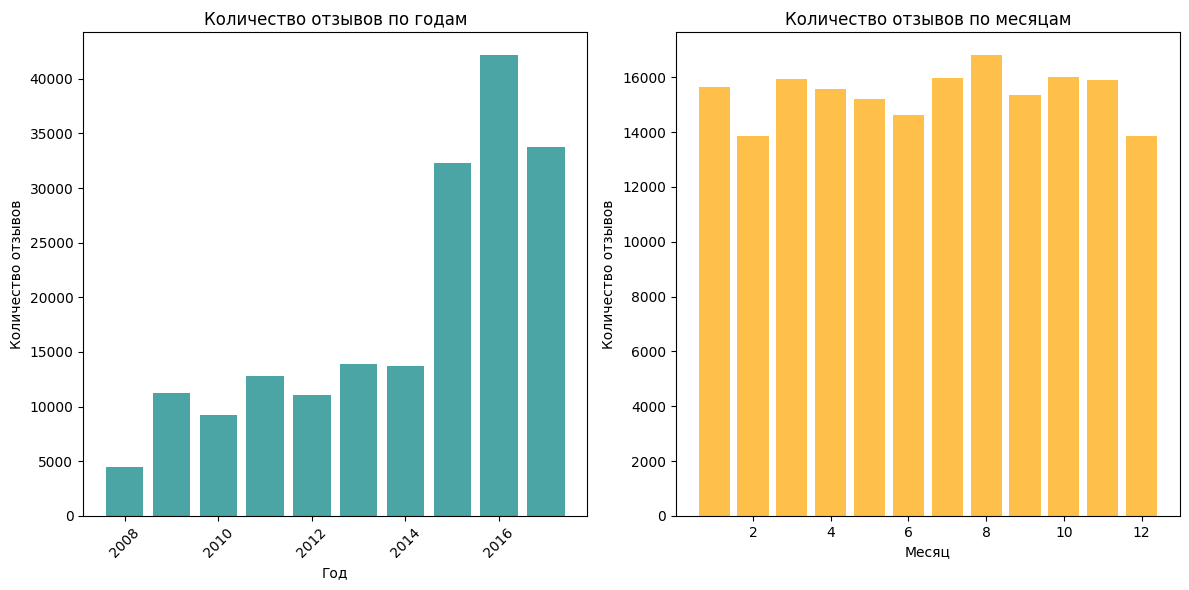

Период данных: 2008-02-24 00:00:00 - 2017-12-12 00:00:00
Всего лет данных: 10


In [63]:
print("\nАнализ временных паттернов...")

all_data['date'] = pd.to_datetime(all_data['date'])
all_data['year'] = all_data['date'].dt.year
all_data['month'] = all_data['date'].dt.month
all_data['year_month'] = all_data['date'].dt.to_period('M')

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
yearly_counts = all_data['year'].value_counts().sort_index()
plt.bar(yearly_counts.index, yearly_counts.values, alpha=0.7, color='teal')
plt.title('Количество отзывов по годам')
plt.xlabel('Год')
plt.ylabel('Количество отзывов')
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
monthly_counts = all_data['month'].value_counts().sort_index()
plt.bar(monthly_counts.index, monthly_counts.values, alpha=0.7, color='orange')
plt.title('Количество отзывов по месяцам')
plt.xlabel('Месяц')
plt.ylabel('Количество отзывов')

plt.tight_layout()
plt.show()

print(f"Период данных: {all_data['date'].min()} - {all_data['date'].max()}")
print(f"Всего лет данных: {all_data['year'].nunique()}")


Анализ взаимосвязей между признаками...


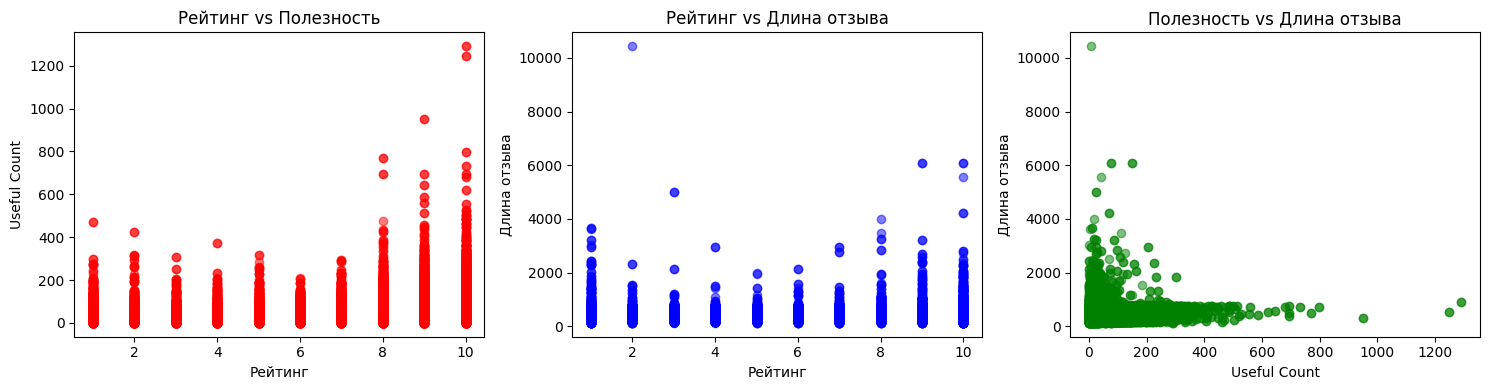


Корреляционная матрица:
                 rating  usefulCount  review_length
rating         1.000000     0.243629       0.028708
usefulCount    0.243629     1.000000       0.015204
review_length  0.028708     0.015204       1.000000


In [64]:
print("\nАнализ взаимосвязей между признаками...")

numeric_data = all_data[['rating', 'usefulCount', 'review_length']].copy()

plt.figure(figsize=(15, 4))

plt.subplot(1, 3, 1)
plt.scatter(numeric_data['rating'], numeric_data['usefulCount'], alpha=0.5, color='red')
plt.title('Рейтинг vs Полезность')
plt.xlabel('Рейтинг')
plt.ylabel('Useful Count')

plt.subplot(1, 3, 2)
plt.scatter(numeric_data['rating'], numeric_data['review_length'], alpha=0.5, color='blue')
plt.title('Рейтинг vs Длина отзыва')
plt.xlabel('Рейтинг')
plt.ylabel('Длина отзыва')

plt.subplot(1, 3, 3)
plt.scatter(numeric_data['usefulCount'], numeric_data['review_length'], alpha=0.5, color='green')
plt.title('Полезность vs Длина отзыва')
plt.xlabel('Useful Count')
plt.ylabel('Длина отзыва')

plt.tight_layout()
plt.show()

correlation_matrix = numeric_data.corr()
print("\nКорреляционная матрица:")
print(correlation_matrix)

#### Детальный анализ по парам:

1. **Рейтинг (`rating`) vs Полезность (`usefulCount`)**
*   **Коэффициент корреляции: `0.24`**
*   **Интерпретация: Слабая положительная корреляция.**
*   **Что это означает:**
    *   Существует очень слабая тенденция того, что отзывы с более высоким рейтингом  получают немного больше голосов "полезно".


2. **Рейтинг (`rating`) vs Длина отзыва (`review_length`)**
*   **Коэффициент корреляции: `0.03`**
*   **Интерпретация: Практически отсутствует корреляция.**
*   **Что это означает:**
    *   **Длина отзыва не зависит от того, положительный он или отрицательный.** 

3. **Полезность (`usefulCount`) vs Длина отзыва (`review_length`)**
*   **Коэффициент корреляции: `0.015`**
*   **Интерпретация: Корреляция отсутствует.**
*   **Что это означает:**
    *   **Полезность отзыва практически не связана с его длиной.** Пользователи не считают длинные отзывы автоматически более полезными.



Анализ самых обсуждаемых лекарств...


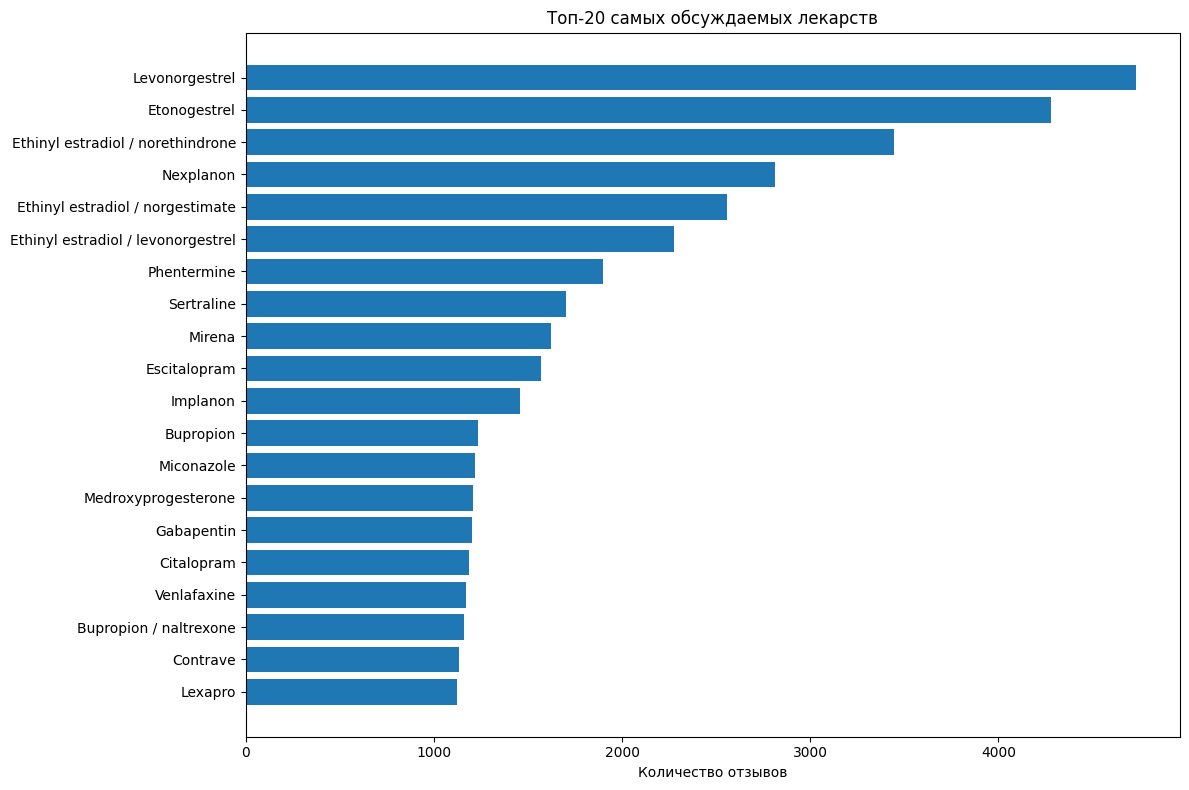

Топ-10 самых обсуждаемых лекарств:
  1. Levonorgestrel: 4728 отзывов, ср. рейтинг: 7.4, ср. полезность: 10.6
  2. Etonogestrel: 4277 отзывов, ср. рейтинг: 5.8, ср. полезность: 6.8
  3. Ethinyl estradiol / norethindrone: 3446 отзывов, ср. рейтинг: 5.6, ср. полезность: 8.0
  4. Nexplanon: 2812 отзывов, ср. рейтинг: 5.7, ср. полезность: 6.0
  5. Ethinyl estradiol / norgestimate: 2559 отзывов, ср. рейтинг: 5.8, ср. полезность: 8.3
  6. Ethinyl estradiol / levonorgestrel: 2274 отзывов, ср. рейтинг: 5.7, ср. полезность: 7.2
  7. Phentermine: 1898 отзывов, ср. рейтинг: 8.8, ср. полезность: 29.6
  8. Sertraline: 1702 отзывов, ср. рейтинг: 7.5, ср. полезность: 45.6
  9. Mirena: 1624 отзывов, ср. рейтинг: 6.6, ср. полезность: 14.1
  10. Escitalopram: 1572 отзывов, ср. рейтинг: 7.9, ср. полезность: 41.0


In [65]:
print("\nАнализ самых обсуждаемых лекарств...")

top_drugs = all_data['drugName'].value_counts().head(20)

plt.figure(figsize=(12, 8))
plt.barh(range(len(top_drugs)), top_drugs.values)
plt.yticks(range(len(top_drugs)), top_drugs.index)
plt.title('Топ-20 самых обсуждаемых лекарств')
plt.xlabel('Количество отзывов')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print("Топ-10 самых обсуждаемых лекарств:")
for i, (drug, count) in enumerate(top_drugs.head(10).items(), 1):
    drug_avg_rating = all_data[all_data['drugName'] == drug]['rating'].mean()
    drug_avg_useful = all_data[all_data['drugName'] == drug]['usefulCount'].mean()
    print(f"  {i}. {drug}: {count} отзывов, ср. рейтинг: {drug_avg_rating:.1f}, ср. полезность: {drug_avg_useful:.1f}")

1. Тематики  
   - 70% топ-10 — гормональные контрацептивы (1–6, 9)  
   - Антидепрессанты (Sertraline, Escitalopram) и Phentermine

2. Отзывы vs рейтинг  
   - Высокий рейтинг при среднем числе отзывов: Phentermine (8.8), Escitalopram (7.9), Sertraline (7.5), Levonorgestrel (7.4)  
   - Контрацептивы (5.6–5.8) собирают много жалоб

3. Полезность  
   - Лидеры: Sertraline (45.6), Escitalopram (41.0), Phentermine (29.6)  
   - Отзывы по антидепрессантам и похудению наиболее информативны

4. Аномалии  
   - Phentermine: быстрые заметные результаты  
   - Антидепрессанты: подробные описания адаптации

Дальнейший контент-анализ сфокусировать на побочных эффектах контрацептивов, процессе адаптации к антидепрессантам и безопасности Phentermine.


Анализ медицинских специализаций...


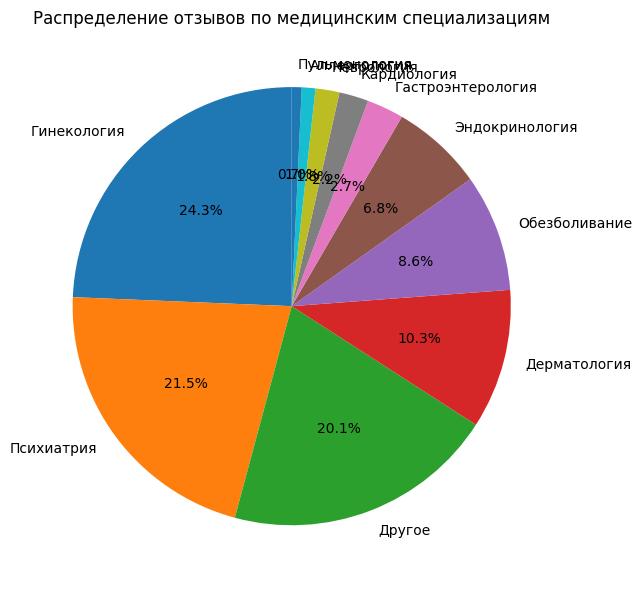

Распределение по медицинским специализациям:
  Гинекология: 44946 отзывов (24.3%)
  Психиатрия: 39646 отзывов (21.5%)
  Другое: 37069 отзывов (20.1%)
  Дерматология: 19001 отзывов (10.3%)
  Обезболивание: 15961 отзывов (8.6%)
  Эндокринология: 12521 отзывов (6.8%)
  Гастроэнтерология: 5016 отзывов (2.7%)
  Кардиология: 3997 отзывов (2.2%)
  Неврология: 3263 отзывов (1.8%)
  Аллергология: 1856 отзывов (1.0%)
  Пульмонология: 1346 отзывов (0.7%)


In [66]:
print("\nАнализ медицинских специализаций...")

def categorize_condition(condition):
    """
    Категоризация медицинских состояний по русским категориям
    """
    if not isinstance(condition, str):
        return 'Другое'
        
    condition_lower = condition.lower()
    
    # словарь категорий и ключевых слов
    categories = {
        'Гинекология': [
            'birth', 'contracep', 'pregn', 'menstrual', 'period', 'ovulation',
            'endometr', 'uterine', 'ovarian', 'menopause', 'hormon', 'estrogen',
            'progesteron', 'pcos', 'fibroid', 'menstruation'
        ],
        'Психиатрия': [
            'depress', 'anxiet', 'bipolar', 'schizo', 'ocd', 'panic', 'stress',
            'mental', 'psych', 'mood', 'insomnia', 'sleep', 'adhd', 'autism',
            'ptsd', 'social anxiety', 'generalized anxiety'
        ],
        'Обезболивание': [
            'pain', 'headache', 'migraine', 'back pain', 'neuropathic', 'arthritis',
            'fibromyalgia', 'chronic pain', 'muscle pain', 'joint pain', 'neck pain'
        ],
        'Дерматология': [
            'acne', 'eczema', 'psoriasis', 'skin', 'dermat', 'rash', 'rosacea',
            'fungal', 'infection', 'allerg', 'hives', 'urticaria', 'pruritus'
        ],
        'Неврология': [
            'migraine', 'epilepsy', 'seizure', 'neuropath', 'alzheimer', 'dementia',
            'parkinson', 'multiple sclerosis', 'ms', 'nerve pain', 'trigeminal'
        ],
        'Кардиология': [
            'blood', 'pressure', 'hypertension', 'heart', 'cardio', 'cholesterol',
            'arrhythmia', 'atrial', 'fibrillation', 'angina', 'myocardial'
        ],
        'Эндокринология': [
            'diabet', 'thyroid', 'hypothyroid', 'hyperthyroid', 'blood sugar',
            'insulin', 'metabol', 'obesity', 'weight', 'testosterone', 'growth'
        ],
        'Гастроэнтерология': [
            'acid', 'reflux', 'gerd', 'ibd', 'ibs', 'crohn', 'colitis', 'stomach',
            'gastro', 'ulcer', 'constipation', 'diarrhea', 'inflammatory bowel'
        ],
        'Аллергология': [
            'allerg', 'asthma', 'hay fever', 'rhinitis', 'sinus', 'pollen',
            'allergic', 'anaphylaxis', 'histamine'
        ],
        'Пульмонология': [
            'asthma', 'copd', 'bronchitis', 'pneumonia', 'lung', 'respirator',
            'breathing', 'chronic obstructive'
        ]
    }
    
    for category, keywords in categories.items():
        for keyword in keywords:
            if keyword in condition_lower:
                return category
    
    return 'Другое'


all_data['condition_category'] = all_data['condition'].apply(categorize_condition)

category_counts = all_data['condition_category'].value_counts()

plt.figure(figsize=(10, 6))
plt.pie(category_counts.values, labels=category_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Распределение отзывов по медицинским специализациям')
plt.tight_layout()
plt.show()

print("Распределение по медицинским специализациям:")
for category, count in category_counts.items():
    percentage = (count / len(all_data)) * 100
    print(f"  {category}: {count} отзывов ({percentage:.1f}%)")

Активность пользователей сконцентрирована вокруг:
1.  **Широких/общих медицинских проблем** ("Другое")
2.  **Репродуктивного здоровья и контрацепции** (Гинекология)
3.  **Психического здоровья** (Психиатрия)


In [67]:
print("СВОДНАЯ СТАТИСТИКА EDA")

print(f"Общий размер датасета: {len(all_data):,} записей")
print(f"Уникальных пациентов: {all_data['patient_id'].nunique():,}")
print(f"Уникальных лекарств: {all_data['drugName'].nunique():,}")
print(f"Уникальных медицинских состояний: {all_data['condition'].nunique():,}")

print(f"\nВременной период: {all_data['date'].min().strftime('%Y-%m-%d')} - {all_data['date'].max().strftime('%Y-%m-%d')}")
print(f"Лет покрытия: {all_data['year'].nunique()}")

print(f"\nСтатистика рейтингов:")
print(f"  Средний: {all_data['rating'].mean():.2f}")
print(f"  Медиана: {all_data['rating'].median():.2f}")
print(f"  Стандартное отклонение: {all_data['rating'].std():.2f}")

print(f"\nСтатистика отзывов:")
print(f"  Средняя длина: {all_data['review_length'].mean():.0f} символов")
print(f"  Медианная длина: {all_data['review_length'].median():.0f} символов")

print(f"\nСтатистика полезности:")
print(f"  Средняя полезность: {all_data['usefulCount'].mean():.1f}")
print(f"  Медианная полезность: {all_data['usefulCount'].median():.1f}")

print(f"\nТоп-3 медицинских состояния:")
for condition, count in all_data['condition'].value_counts().head(3).items():
    print(f"  {condition}: {count} отзывов")

print(f"\nТоп-3 лекарства:")
for drug, count in all_data['drugName'].value_counts().head(3).items():
    avg_rating = all_data[all_data['drugName'] == drug]['rating'].mean()
    print(f"  {drug}: {count} отзывов, ср. рейтинг: {avg_rating:.1f}")

СВОДНАЯ СТАТИСТИКА EDA
Общий размер датасета: 184,622 записей
Уникальных пациентов: 184,622
Уникальных лекарств: 3,247
Уникальных медицинских состояний: 851

Временной период: 2008-02-24 - 2017-12-12
Лет покрытия: 10

Статистика рейтингов:
  Средний: 7.00
  Медиана: 8.00
  Стандартное отклонение: 3.24

Статистика отзывов:
  Средняя длина: 505 символов
  Медианная длина: 503 символов

Статистика полезности:
  Средняя полезность: 28.5
  Медианная полезность: 16.0

Топ-3 медицинских состояния:
  birth control: 36912 отзывов
  depression: 10784 отзывов
  acne: 6933 отзывов

Топ-3 лекарства:
  Levonorgestrel: 4728 отзывов, ср. рейтинг: 7.4
  Etonogestrel: 4277 отзывов, ср. рейтинг: 5.8
  Ethinyl estradiol / norethindrone: 3446 отзывов, ср. рейтинг: 5.6


**Практическая предобработка текста отзывов**

In [68]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

# Скачиваем необходимые ресурсы (если нужно)
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\tabul\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\tabul\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\tabul\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

### Делим данные на сегменты ДО обработки

In [69]:
from sklearn.model_selection import train_test_split

# cтратегическое разделение по препаратам для демонстрации CB подходов
all_drugs = all_data['drugName'].unique()
train_drugs, test_drugs = train_test_split(all_drugs, test_size=0.3, random_state=42)

#  train/test на основе препаратов
train_data_raw = all_data[all_data['drugName'].isin(train_drugs)].copy()
test_data_raw = all_data[all_data['drugName'].isin(test_drugs)].copy()

print("РАЗДЕЛЕНИЕ ДО ОБРАБОТКИ:")
print(f"Train: {len(train_data_raw)} отзывов, {len(train_drugs)} препаратов")
print(f"Test: {len(test_data_raw)} отзывов, {len(test_drugs)} препаратов")

РАЗДЕЛЕНИЕ ДО ОБРАБОТКИ:
Train: 128367 отзывов, 2272 препаратов
Test: 56255 отзывов, 975 препаратов


### Разная предобработка для разных сегментов

In [70]:
def simple_medical_text_preprocessing(text):

    if pd.isna(text):
        return ""

    text = text.lower()
    
    # базовая очистка - сохраняем апострофы для английских сокращений
    text = re.sub(r'[^a-zA-Z\s\']', ' ', text)
    
    # удаление лишних пробелов
    text = re.sub(r'\s+', ' ', text).strip()
    
    #  токенизация через split (вместо word_tokenize)
    tokens = text.split()
    
    #  список стоп-слов для медицинских отзывов
    medical_stopwords = {
        'the', 'a', 'an', 'and', 'or', 'but', 'in', 'on', 'at', 'to', 'for', 'of', 'with', 'by',
        'this', 'that', 'these', 'those', 'is', 'are', 'was', 'were', 'be', 'been', 'being',
        'have', 'has', 'had', 'do', 'does', 'did', 'will', 'would', 'could', 'should', 'may',
        'might', 'must', 'can', 'it', 'its', 'they', 'them', 'their', 'i', 'me', 'my', 'we', 'our'
    }
    
    # стоп-слов +  медицинские термины
    medical_terms = {
        'no', 'not', 'very', 'more', 'most', 'better', 'worse', 'good', 'bad', 
        'effective', 'side', 'effect', 'pain', 'help', 'worked', 'work', 'dose',
        'mg', 'mcg', 'taking', 'took', 'take', 'doctor', 'prescribed', 'medication',
        'drug', 'pill', 'tablet', 'capsule', 'injection', 'symptoms', 'treatment'
    }
    
    final_stopwords = medical_stopwords - medical_terms
    tokens = [token for token in tokens if token not in final_stopwords]
    
    # простая лемматизация через базовые правила (вместо WordNetLemmatizer)
    def simple_lemmatize(token):
        if token.endswith('ing'):
            return token[:-3]
        elif token.endswith('ed'):
            return token[:-2]
        elif token.endswith('s'):
            return token[:-1]
        return token
    
    tokens = [simple_lemmatize(token) for token in tokens]
    
    return ' '.join(tokens)


train_data_raw['cleaned_review'] = train_data_raw['review'].apply(simple_medical_text_preprocessing)
test_data_raw['cleaned_review'] = test_data_raw['review'].apply(simple_medical_text_preprocessing)


### Проверяем результаты разделения и обработки

In [71]:
print("\nПРОВЕРКА РАЗДЕЛЕНИЯ:")
print(" TRAIN данные:")
print(f"Препараты: {train_data_raw['drugName'].unique()[:5]}...")
print(f"Пример очищенного текста: {train_data_raw['cleaned_review'].iloc[0][:300]}...")

print("\n TEST данные:") 
print(f"Препараты: {test_data_raw['drugName'].unique()[:5]}...")
print(f"Пример очищенного текста: {test_data_raw['cleaned_review'].iloc[0][:300]}...")

print(f"\nПересечение препаратов: {set(train_drugs) & set(test_drugs)}")  


ПРОВЕРКА РАЗДЕЛЕНИЯ:
 TRAIN данные:
Препараты: ['Etonogestrel' 'Implanon' 'Hydroxyzine' 'Dalfampridine' 'Tri-Sprintec']...
Пример очищенного текста: experience somewhat mix us implanon now nearly month decid get remov because ble every day all day occasionally stain underwear sheet didn't start out way first month didn't ble all then epic two week period then everyth irregular which basically new norm sadly decid get rid implanon because endles ...

 TEST данные:
Препараты: ['Cyclosporine' 'Epiduo' 'Depo-Provera' 'Buprenorphine' 'Aromasin']...
Пример очищенного текста: us restasi about year now seen almost no progres most life i've r bothersome eye after try variou eye drop doctor recommend restasi he said typically take month really kick never kick when put drop burn eye first minute i've talk doctor about he said normal go away after some time hasn't every year ...

Пересечение препаратов: set()


- Train: известные препараты (Etonogestrel, Implanon, Hydroxyzine...)

- Test: новые препараты (Cyclosporine, Epiduo, Depo-Provera...)

- Задача: рекомендовать препараты из TEST на основе схожести с TRAIN

In [72]:
train_data_raw.info()

<class 'pandas.core.frame.DataFrame'>
Index: 128367 entries, 1 to 184620
Data columns (total 13 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   patient_id          128367 non-null  int64         
 1   drugName            128367 non-null  object        
 2   condition           128367 non-null  object        
 3   review              128367 non-null  object        
 4   rating              128367 non-null  float64       
 5   date                128367 non-null  datetime64[ns]
 6   usefulCount         128367 non-null  int64         
 7   review_length       128367 non-null  int64         
 8   year                128367 non-null  int32         
 9   month               128367 non-null  int32         
 10  year_month          128367 non-null  period[M]     
 11  condition_category  128367 non-null  object        
 12  cleaned_review      128367 non-null  object        
dtypes: datetime64[ns](1), float64(1), 

In [73]:
# распределение по специализациям
print("РАСПРЕДЕЛЕНИЕ ПО СПЕЦИАЛИЗАЦИЯМ:")
print("TRAIN:", train_data_raw['condition_category'].value_counts(normalize=True).head(3))
print()
print("TEST:", test_data_raw['condition_category'].value_counts(normalize=True).head(3))

РАСПРЕДЕЛЕНИЕ ПО СПЕЦИАЛИЗАЦИЯМ:
TRAIN: condition_category
Гинекология    0.275071
Другое         0.204570
Психиатрия     0.202809
Name: proportion, dtype: float64

TEST: condition_category
Психиатрия     0.241970
Другое         0.192143
Гинекология    0.171291
Name: proportion, dtype: float64


### Создаем фичи для рекомендательной системы

In [74]:
# Для train данных
train_data_raw['review_word_count'] = train_data_raw['cleaned_review'].apply(lambda x: len(x.split()))
train_data_raw['has_side_effects'] = train_data_raw['cleaned_review'].str.contains('side effect|nausea|headache', case=False)

# Для test данных  
test_data_raw['review_word_count'] = test_data_raw['cleaned_review'].apply(lambda x: len(x.split()))
test_data_raw['has_side_effects'] = test_data_raw['cleaned_review'].str.contains('side effect|nausea|headache', case=False)

print("\nФИЧИ ДЛЯ RS:")
print(f"Train - средняя длина: {train_data_raw['review_word_count'].mean():.1f} слов")
print(f"Test - средняя длина: {test_data_raw['review_word_count'].mean():.1f} слов")


ФИЧИ ДЛЯ RS:
Train - средняя длина: 57.6 слов
Test - средняя длина: 55.9 слов


In [75]:
train_data_raw.head()

,patient_id,drugName,condition,review,rating,date,usefulCount,review_length,year,month,year_month,condition_category,cleaned_review,review_word_count,has_side_effects
1,143975,Etonogestrel,birth control,"""My experience has been somewhat mixed. I have...",7.0,2016-08-07,4,759,2016,8,2016-08,Гинекология,experience somewhat mix us implanon now nearly...,83,True
2,106473,Implanon,birth control,"""This is my second Implanon would not recommen...",1.0,2016-05-11,6,738,2016,5,2016-05,Гинекология,second implanon not recommend all first one ok...,81,False
3,184526,Hydroxyzine,anxiety,"""I recommend taking as prescribed, and the bot...",10.0,2012-03-19,124,534,2012,3,2012-03,Психиатрия,recommend tak a prescrib bottle usually say ta...,66,True
4,91587,Dalfampridine,multiple sclerosis,"""I have been on Ampyra for 5 days and have bee...",9.0,2010-08-01,101,373,2010,8,2010-08,Неврология,ampyra day so happy new pill first day not goo...,43,True
5,218554,Tri-Sprintec,birth control,"""Used for birth control and period issues- ver...",2.0,2017-01-07,4,354,2017,1,2017-01,Гинекология,us birth control period issue very unhappy wor...,41,True


#### ТЕОРЕТИЧЕСКАЯ ЧАСТЬ: Векторизация в РС

##### Зачем векторизуем текст в РС?
- Преобразуем тексты в **числовые векторы**
- Вычисляем **схожесть** между препаратами
- Строим **content-based рекомендации**

**Content-Based подход** рекомендует объекты, похожие на те, которые пользователь предпочитал в прошлом, на основе **характеристик и содержания** самих объектов.

#### Ключевые Компоненты

##### 1. Item Profile (Профиль объекта)
- Вектор признаков, описывающих объект
- Для лекарств: текст отзывов, рейтинг, категория, побочные эффекты
- Формально: `item_i = {feature_1, feature_2, ..., feature_n}`

##### 2. User Profile (Профиль пользователя) 
- Обобщенный профиль на основе предпочитаемых объектов
- Средневзвешенный вектор предпочитаемых профилей объекта
- Формально: `user_u = aggregate(items_liked_by_u)`

##### 3. Функция Схожести
- Измеряет близость между user profile и item profile
- Наиболее популярно: косинусная схожесть, евклидово расстояние

### Косинусная Схожесть
```
similarity(A,B) = (A · B) / (||A|| × ||B||)
```



---
#### **TF-IDF Векторизация**

##### **Теория TF-IDF:**
```python
# TF (Term Frequency) - как часто слово встречается в документе
TF = (число вхождений слова в документе) / (общее число слов в документе)

# IDF (Inverse Document Frequency) - насколько слово редкое в коллекции  
IDF = log(общее число документов / число документов со словом)

TF-IDF = TF * IDF
```

**Преимущества для RS:**
- Учитывает важность слов в контексте коллекции
- Автоматически понижает вес частых, но малосодержательных слов


In [76]:
from sklearn.feature_extraction.text import TfidfVectorizer

# TF-IDF векторизатор с медицинским контекстом
tfidf_vectorizer = TfidfVectorizer(
    max_features=2000,           # ограничим размерность для скорости
    stop_words='english',        # базовые английские стоп-слова
    ngram_range=(1, 3),          # уни-, би- и триграммы
    min_df=5,                    # игнорируем очень редкие термины
    max_df=0.7                   # игнорируем слишком частые термины
)


print("TF-IDF ВЕКТОРИЗАЦИЯ...")
train_tfidf = tfidf_vectorizer.fit_transform(train_data_raw['cleaned_review'])
test_tfidf = tfidf_vectorizer.transform(test_data_raw['cleaned_review'])

print(f"Размерность TF-IDF векторов:")
print(f"Train: {train_tfidf.shape}")
print(f"Test: {test_tfidf.shape}")
print(f"Словарь: {len(tfidf_vectorizer.get_feature_names_out())} терминов")

TF-IDF ВЕКТОРИЗАЦИЯ...
Размерность TF-IDF векторов:
Train: (128367, 2000)
Test: (56255, 2000)
Словарь: 2000 терминов


##### **Анализ TF-IDF результатов:**

In [77]:
feature_names = tfidf_vectorizer.get_feature_names_out()
top_terms_idx = train_tfidf.mean(axis=0).argsort()[0, -20:][::-1]
top_terms = feature_names[top_terms_idx]

print("Топ-20 важных терминов по TF-IDF:")
print(top_terms)

Топ-20 важных терминов по TF-IDF:
[['doctor' 'help' 'medication' 'just' 'like' 'pill' 'time' 'tak' 'pain'
  'period' 'mg' 've' 'feel' 'start' 'effect' 'work' 'week' 'year' 'month'
  'day']]


### **BERT Векторизация**

##### **Теория BERT:**
- **Transformer архитектура** - учитывает контекст слова в предложении
- **Двунаправленное кодирование** - понимает смысл с двух сторон
- **Контекстуальные эмбеддинги** - одно слово имеет разные векторы в разных контекстах

In [78]:
from sentence_transformers import SentenceTransformer
import numpy as np

print("ЗАГРУЗКА BERT МОДЕЛИ...")
bert_model = SentenceTransformer('cambridgeltl/SapBERT-from-PubMedBERT-fulltext').cuda()

def get_bert_embeddings(texts, batch_size=32):
    embeddings = []
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i + batch_size].tolist()
        batch_embeddings = bert_model.encode(batch)
        embeddings.extend(batch_embeddings)
    return np.array(embeddings)

print("BERT ВЕКТОРИЗАЦИЯ TRAIN...")
train_bert = get_bert_embeddings(train_data_raw['cleaned_review'])

print("BERT ВЕКТОРИЗАЦИЯ TEST...") 
test_bert = get_bert_embeddings(test_data_raw['cleaned_review'])

print(f"Размерность BERT векторов: {train_bert.shape}")

ЗАГРУЗКА BERT МОДЕЛИ...


No sentence-transformers model found with name cambridgeltl/SapBERT-from-PubMedBERT-fulltext. Creating a new one with mean pooling.


config.json:   0%|          | 0.00/462 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/198 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

BERT ВЕКТОРИЗАЦИЯ TRAIN...
BERT ВЕКТОРИЗАЦИЯ TEST...
Размерность BERT векторов: (128367, 768)


#### **Проверка качества векторизации:**

In [79]:
# примеры отзывов для тестирования
sample_drugs = train_data_raw['drugName'].value_counts().index[:3]
print("СРАВНЕНИЕ КАЧЕСТВА ВЕКТОРИЗАЦИИ")
print("Что сравниваем: схожесть двух случайных отзывов об ОДНОМ препарате\n")

for drug in sample_drugs:
    drug_reviews = train_data_raw[train_data_raw['drugName'] == drug]
    if len(drug_reviews) > 1:
        reviews_sample = drug_reviews['cleaned_review'].head(2).tolist()
        
        # TF-IDF векторизация и схожесть
        tfidf_vectors = tfidf_vectorizer.transform(reviews_sample)
        tfidf_similarity = cosine_similarity(tfidf_vectors[0:1], tfidf_vectors[1:2])[0][0]
        
        # BERT векторизация и схожесть  
        bert_vectors = bert_model.encode(reviews_sample)
        bert_similarity = cosine_similarity(bert_vectors[0:1], bert_vectors[1:2])[0][0]
        
        print(f"ПРЕПАРАТ: {drug}")
        print(f"   Отзыв 1: '{reviews_sample[0][:80]}...'")
        print(f"   Отзыв 2: '{reviews_sample[1][:80]}...'")
        print(f"   TF-IDF схожесть: {tfidf_similarity:.3f}")
        print(f"   BERT схожесть:   {bert_similarity:.3f}")
        print(f"   Разница: {abs(tfidf_similarity - bert_similarity):.3f}")
        
        if tfidf_similarity < 0.3:
            print("   TF-IDF: НИЗКАЯ схожесть - видит РАЗНЫЕ слова")
        else:
            print("   TF-IDF: ВЫСОКАЯ схожесть - видит ПОХОЖИЕ слова")
            
        if bert_similarity > 0.5:
            print("   BERT: ВЫСОКАЯ схожесть - понимает ОДИН препарат")
        else:
            print("   BERT: НИЗКАЯ схожесть - отзывы действительно разные")
        print()

СРАВНЕНИЕ КАЧЕСТВА ВЕКТОРИЗАЦИИ
Что сравниваем: схожесть двух случайных отзывов об ОДНОМ препарате

ПРЕПАРАТ: Levonorgestrel
   Отзыв 1: 'hi everyone so period june th very last day boyfriend sex condom some how both f...'
   Отзыв 2: 'said if got through write review ease people' mind i'm guy girl sex vagina felt ...'
   TF-IDF схожесть: 0.226
   BERT схожесть:   0.749
   Разница: 0.523
   TF-IDF: НИЗКАЯ схожесть - видит РАЗНЫЕ слова
   BERT: ВЫСОКАЯ схожесть - понимает ОДИН препарат

ПРЕПАРАТ: Etonogestrel
   Отзыв 1: 'experience somewhat mix us implanon now nearly month decid get remov because ble...'
   Отзыв 2: 'well ask doctor birth control not make gain weight got nexplanon lost weight not...'
   TF-IDF схожесть: 0.029
   BERT схожесть:   0.646
   Разница: 0.617
   TF-IDF: НИЗКАЯ схожесть - видит РАЗНЫЕ слова
   BERT: ВЫСОКАЯ схожесть - понимает ОДИН препарат

ПРЕПАРАТ: Ethinyl estradiol / norethindrone
   Отзыв 1: 'us use depo provera year then went through yr no period then ca

### Тест на семантически близких препаратах

In [80]:
# Тест на семантически близких препаратах
print("СРАВНЕНИЕ РОДСТВЕННЫХ ПРЕПАРАТОВ")
print("Что сравниваем: схожесть отзывов о РАЗНЫХ препаратах из одной категории\n")

# гинекологические препараты
gynecology_drugs = ['Etonogestrel', 'Levonorgestrel', 'Nexplanon']
gynecology_reviews = []

for drug in gynecology_drugs:
    drug_review = train_data_raw[train_data_raw['drugName'] == drug]['cleaned_review']
    if len(drug_review) > 0:
        gynecology_reviews.append((drug, drug_review.iloc[0]))

print("ГИНЕКОЛОГИЧЕСКИЕ ПРЕПАРАТЫ:")
for i in range(len(gynecology_reviews)):
    for j in range(i+1, len(gynecology_reviews)):
        drug1, review1 = gynecology_reviews[i]
        drug2, review2 = gynecology_reviews[j]
        
        # TF-IDF
        tfidf_vec1 = tfidf_vectorizer.transform([review1])
        tfidf_vec2 = tfidf_vectorizer.transform([review2])
        tfidf_sim = cosine_similarity(tfidf_vec1, tfidf_vec2)[0][0]
        
        # BERT
        bert_vec1 = bert_model.encode([review1])
        bert_vec2 = bert_model.encode([review2]) 
        bert_sim = cosine_similarity(bert_vec1, bert_vec2)[0][0]
        
        print(f"   {drug1} vs {drug2}:")
        print(f"      TF-IDF: {tfidf_sim:.3f} - текстовое сходство")
        print(f"      BERT:   {bert_sim:.3f} - семантическое сходство")
        
        # анализ для рекомендаций
        if bert_sim > 0.6:
            print(f"      BERT: СХОЖИЕ препараты - можно рекомендовать")
        elif bert_sim > 0.4:
            print(f"      BERT: УМЕРЕННО схожи - возможны рекомендации") 
        else:
            print(f"      BERT: НЕСХОЖИЕ препараты - не рекомендовать")
        print()

СРАВНЕНИЕ РОДСТВЕННЫХ ПРЕПАРАТОВ
Что сравниваем: схожесть отзывов о РАЗНЫХ препаратах из одной категории

ГИНЕКОЛОГИЧЕСКИЕ ПРЕПАРАТЫ:
   Etonogestrel vs Levonorgestrel:
      TF-IDF: 0.072 - текстовое сходство
      BERT:   0.650 - семантическое сходство
      BERT: СХОЖИЕ препараты - можно рекомендовать

   Etonogestrel vs Nexplanon:
      TF-IDF: 0.043 - текстовое сходство
      BERT:   0.607 - семантическое сходство
      BERT: СХОЖИЕ препараты - можно рекомендовать

   Levonorgestrel vs Nexplanon:
      TF-IDF: 0.026 - текстовое сходство
      BERT:   0.683 - семантическое сходство
      BERT: СХОЖИЕ препараты - можно рекомендовать



### Анализ семантических возможностей BERT

In [81]:
print("ТЕСТ НА СЕМАНТИЧЕСКОЕ ПОНИМАНИЕ:\n")

test_texts = [
    "I have terrible headaches and nausea",
    "I experience severe migraines and sickness",  # синонимы
    "The medication works great for pain relief",  # другой контекст
    "This drug is amazing for pain management"     # похожий контекст
]

test_tfidf = tfidf_vectorizer.transform(test_texts)
test_bert = bert_model.encode(test_texts)

tfidf_similarity = cosine_similarity(test_tfidf)
bert_similarity = cosine_similarity(test_bert)

print("TF-IDF МАТРИЦА СХОЖЕСТИ:")
print(tfidf_similarity)
print("\nBERT МАТРИЦА СХОЖЕСТИ:")
print(bert_similarity)

print("\nДЕТАЛЬНЫЙ АНАЛИЗ СХОЖЕСТИ:")

# анализ пар текстов
pairs_to_analyze = [
    (0, 1, "Синонимы (headaches/migraines, nausea/sickness)"),
    (2, 3, "Похожий контекст (pain relief/pain management)"),
    (0, 2, "Разные контексты (побочки vs эффективность)"),
    (1, 3, "Разные контексты (симптомы vs лечение)")
]

print("\nСРАВНЕНИЕ СХОЖЕСТИ ДЛЯ КЛЮЧЕВЫХ ПАР:")
for i, j, description in pairs_to_analyze:
    tfidf_score = tfidf_similarity[i, j]
    bert_score = bert_similarity[i, j]
    
    print(f"\n{description}:")
    print(f"  TF-IDF: {tfidf_score:.3f}")
    print(f"  BERT:   {bert_score:.3f}")
    print(f"  Разница: {bert_score - tfidf_score:+.3f}")
    

    if bert_score > 0.7:
        print("  ✓ BERT: ВЫСОКАЯ семантическая схожесть")
    elif bert_score > 0.4:
        print("  ○ BERT: УМЕРЕННАЯ схожесть")
    else:
        print("  ✗ BERT: НИЗКАЯ схожесть")
        
    if tfidf_score > 0.3:
        print("  ○ TF-IDF: Есть лексические пересечения")
    else:
        print("  ✗ TF-IDF: Нет лексических пересечений")


print("ВЫВОДЫ:")
synonym_tfidf = tfidf_similarity[0, 1]
synonym_bert = bert_similarity[0, 1]
print(f"СИНОНИМЫ (0-1):")
print(f"  TF-IDF: {synonym_tfidf:.3f} - не видит связи (разные слова)")
print(f"  BERT:   {synonym_bert:.3f} - понимает семантическую близость")
print(f"  Улучшение: {synonym_bert - synonym_tfidf:+.3f}")

context_tfidf = tfidf_similarity[2, 3]
context_bert = bert_similarity[2, 3]
print(f"\nПОХОЖИЙ КОНТЕКСТ (2-3):")
print(f"  TF-IDF: {context_tfidf:.3f} - частичное лексическое совпадение")
print(f"  BERT:   {context_bert:.3f} - понимает общую тему")
print(f"  Улучшение: {context_bert - context_tfidf:+.3f}")

print("\nОБЩИЙ ВЕРДИКТ:")
if bert_similarity[0, 1] > 0.6 and bert_similarity[2, 3] > 0.6:
    print("✓ BERT успешно понимает семантические связи и синонимы")
else:
    print("✗ BERT испытывает трудности с семантическим пониманием")

if tfidf_similarity[0, 1] < 0.1:
    print("✓ TF-IDF работает только на уровне точного совпадения слов")
else:
    print("○ TF-IDF обнаружил случайные лексические пересечения")

ТЕСТ НА СЕМАНТИЧЕСКОЕ ПОНИМАНИЕ:

TF-IDF МАТРИЦА СХОЖЕСТИ:
[[1.         0.         0.         0.        ]
 [0.         1.         0.         0.        ]
 [0.         0.         1.         0.18558258]
 [0.         0.         0.18558258 1.        ]]

BERT МАТРИЦА СХОЖЕСТИ:
[[1.0000001  0.7053633  0.4379209  0.40573463]
 [0.7053633  1.0000002  0.5515721  0.456941  ]
 [0.4379209  0.5515721  0.99999994 0.7744416 ]
 [0.40573463 0.456941   0.7744416  0.9999999 ]]

ДЕТАЛЬНЫЙ АНАЛИЗ СХОЖЕСТИ:

СРАВНЕНИЕ СХОЖЕСТИ ДЛЯ КЛЮЧЕВЫХ ПАР:

Синонимы (headaches/migraines, nausea/sickness):
  TF-IDF: 0.000
  BERT:   0.705
  Разница: +0.705
  ✓ BERT: ВЫСОКАЯ семантическая схожесть
  ✗ TF-IDF: Нет лексических пересечений

Похожий контекст (pain relief/pain management):
  TF-IDF: 0.186
  BERT:   0.774
  Разница: +0.589
  ✓ BERT: ВЫСОКАЯ семантическая схожесть
  ✗ TF-IDF: Нет лексических пересечений

Разные контексты (побочки vs эффективность):
  TF-IDF: 0.000
  BERT:   0.438
  Разница: +0.438
  ○ BERT: УМЕРЕН

## Построение Conten-Based РС

### Базовый алгоритм рекомендаций

In [82]:
class ContentBasedRecommender:
    def __init__(self, tfidf_vectors, bert_vectors, drug_names, drug_to_index_map):
        self.tfidf_vectors = tfidf_vectors
        self.bert_vectors = bert_vectors
        self.drug_names = drug_names
        self.drug_to_index = drug_to_index_map
    
    def recommend_similar_drugs(self, target_drug, top_n=5, method='bert'):
        """
        Рекомендация похожих препаратов на основе контента
        """
        if target_drug not in self.drug_to_index:
            print(f"Препарат {target_drug} не найден в обучающих данных")
            return []
        
        target_idx = self.drug_to_index[target_drug]
        
        if method == 'tfidf':
            vectors = self.tfidf_vectors
        else:  # bert
            vectors = self.bert_vectors
        
        # схожесть со всеми препаратами
        if method == 'tfidf':
            similarities = cosine_similarity(vectors[target_idx:target_idx+1], vectors).flatten()
        else:
            similarities = cosine_similarity([vectors[target_idx]], vectors).flatten()
        
        # топ-N самых похожих (исключая сам препарат)
        similar_indices = similarities.argsort()[::-1][1:top_n+1]
        
        recommendations = []
        for idx in similar_indices:
            if idx < len(self.drug_names):  # проверка границ
                recommendations.append({
                    'drug': self.drug_names[idx],
                    'similarity': similarities[idx],
                    'method': method
                })
            else:
                print(f"Предупреждение: индекс {idx} выходит за границы списка препаратов")
        
        return recommendations

### Сравнение рекомендаций TF-IDF vs BERT

In [83]:
print("Создание отображения препаратов...")
train_drug_names = train_data_raw['drugName'].unique()
drug_to_index_map = {drug: idx for idx, drug in enumerate(train_drug_names)}

print(f"Уникальных препаратов в train: {len(train_drug_names)}")
print(f"Размер TF-IDF векторов: {train_tfidf.shape}")
print(f"Размер BERT векторов: {train_bert.shape}")

#  соответствие размеров
if len(train_drug_names) != train_tfidf.shape[0]:
    print("ВНИМАНИЕ: Количество препаратов не совпадает с количеством векторов!")
    print("Создаем выровненные данные...")
    
    # выровненные данные
    aligned_drugs = []
    aligned_tfidf_indices = []
    aligned_bert_indices = []
    
    for idx, drug in enumerate(train_drug_names):
        if idx < train_tfidf.shape[0] and idx < train_bert.shape[0]:
            aligned_drugs.append(drug)
            aligned_tfidf_indices.append(idx)
            aligned_bert_indices.append(idx)
    

    train_drug_names = np.array(aligned_drugs)
    train_tfidf = train_tfidf[aligned_tfidf_indices]
    train_bert = train_bert[aligned_bert_indices]
    drug_to_index_map = {drug: idx for idx, drug in enumerate(train_drug_names)}

print(f"После выравнивания:")
print(f"Уникальных препаратов: {len(train_drug_names)}")
print(f"Размер TF-IDF векторов: {train_tfidf.shape}")
print(f"Размер BERT векторов: {train_bert.shape}")

Создание отображения препаратов...
Уникальных препаратов в train: 2272
Размер TF-IDF векторов: (128367, 2000)
Размер BERT векторов: (128367, 768)
ВНИМАНИЕ: Количество препаратов не совпадает с количеством векторов!
Создаем выровненные данные...
После выравнивания:
Уникальных препаратов: 2272
Размер TF-IDF векторов: (2272, 2000)
Размер BERT векторов: (2272, 768)


In [84]:
recommender = ContentBasedRecommender(
    tfidf_vectors=train_tfidf, 
    bert_vectors=train_bert,
    drug_names=train_drug_names,
    drug_to_index_map=drug_to_index_map
)

In [85]:
def compare_recommendations(target_drug, top_n=5):
    """
    Сравнение рекомендаций от двух методов
    """
    print(f"РЕКОМЕНДАЦИИ ДЛЯ: {target_drug}")
    
    # наличие препарата
    if target_drug not in drug_to_index_map:
        print(f"Препарат {target_drug} не найден в обучающих данных")
        return [], []
    
    tfidf_recs = recommender.recommend_similar_drugs(target_drug, top_n, method='tfidf')
    print("\nTF-IDF РЕКОМЕНДАЦИИ:")
    for i, rec in enumerate(tfidf_recs, 1):
        print(f"{i}. {rec['drug']} (схожесть: {rec['similarity']:.3f})")
    
    bert_recs = recommender.recommend_similar_drugs(target_drug, top_n, method='bert')
    print("\nBERT РЕКОМЕНДАЦИИ:")
    for i, rec in enumerate(bert_recs, 1):
        print(f"{i}. {rec['drug']} (схожесть: {rec['similarity']:.3f})")
    
    return tfidf_recs, bert_recs


test_drugs = ['Levonorgestrel', 'Sertraline', 'Escitalopram']
print("ЗАПУСК СРАВНЕНИЯ РЕКОМЕНДАЦИЙ")

for drug in test_drugs:
    print(f"\nАНАЛИЗ ДЛЯ ПРЕПАРАТА: {drug}")
    tfidf_recs, bert_recs = compare_recommendations(drug)
    
    if tfidf_recs or bert_recs:
        # анализ качества рекомендаций
        target_category = train_data_raw[train_data_raw['drugName'] == drug]['condition_category'].iloc[0]
        print(f"\nЦелевая категория: {target_category}")
        
        # анализ TF-IDF рекомендаций
        tfidf_categories = []
        for rec in tfidf_recs:
            rec_data = train_data_raw[train_data_raw['drugName'] == rec['drug']]
            if len(rec_data) > 0:
                rec_category = rec_data['condition_category'].iloc[0]
                tfidf_categories.append(rec_category)
        
        # анализ BERT рекомендаций
        bert_categories = []
        for rec in bert_recs:
            rec_data = train_data_raw[train_data_raw['drugName'] == rec['drug']]
            if len(rec_data) > 0:
                rec_category = rec_data['condition_category'].iloc[0]
                bert_categories.append(rec_category)
        
        print(f"TF-IDF категории: {tfidf_categories}")
        print(f"BERT категории: {bert_categories}")
        
        # релевантность
        tfidf_relevant = sum(1 for cat in tfidf_categories if cat == target_category)
        bert_relevant = sum(1 for cat in bert_categories if cat == target_category)
        
        print(f"TF-IDF релевантных: {tfidf_relevant}/{len(tfidf_recs)} ({tfidf_relevant/len(tfidf_recs)*100 if tfidf_recs else 0:.1f}%)")
        print(f"BERT релевантных: {bert_relevant}/{len(bert_recs)} ({bert_relevant/len(bert_recs)*100 if bert_recs else 0:.1f}%)")
    


ЗАПУСК СРАВНЕНИЯ РЕКОМЕНДАЦИЙ

АНАЛИЗ ДЛЯ ПРЕПАРАТА: Levonorgestrel
РЕКОМЕНДАЦИИ ДЛЯ: Levonorgestrel

TF-IDF РЕКОМЕНДАЦИИ:
1. Bextra (схожесть: 0.270)
2. Terazosin (схожесть: 0.236)
3. Benicar HCT (схожесть: 0.232)
4. Neosporin (схожесть: 0.223)
5. Rajani (схожесть: 0.221)

BERT РЕКОМЕНДАЦИИ:
1. Fluzone (схожесть: 0.805)
2. Xylometazoline (схожесть: 0.804)
3. Cleocin (схожесть: 0.800)
4. Dalmane (схожесть: 0.798)
5. Valsartan (схожесть: 0.790)

Целевая категория: Гинекология
TF-IDF категории: ['Обезболивание', 'Другое', 'Кардиология', 'Дерматология', 'Гинекология']
BERT категории: ['Другое', 'Другое', 'Дерматология', 'Психиатрия', 'Кардиология']
TF-IDF релевантных: 1/5 (20.0%)
BERT релевантных: 0/5 (0.0%)

АНАЛИЗ ДЛЯ ПРЕПАРАТА: Sertraline
РЕКОМЕНДАЦИИ ДЛЯ: Sertraline

TF-IDF РЕКОМЕНДАЦИИ:
1. Amerge (схожесть: 0.218)
2. Pramoxine (схожесть: 0.189)
3. Relistor (схожесть: 0.186)
4. Proctosol-HC (схожесть: 0.173)
5. Lorcet (схожесть: 0.173)

BERT РЕКОМЕНДАЦИИ:
1. Zyloprim (схожесть: 0.806)



## Гибридные Подходы

### 1. Weighted Hybrid
```
final_score = α × CB_score + (1-α) × CF_score
```
- Комбинирование взвешенных оценок от разных моделей
- α подбирается на валидационных данных

### 2. Feature Combination
```
combined_features = [CB_features, CF_features, metadata_features]
```
- Объединение признаков из разных источников
- Обучение единой модели на комбинированных признаках

### 3. Cascade Hybrid
```
recommendations = CB_filter(CF_recommendations)
```
- Последовательное применение моделей
- Первая модель создает кандидатов, вторая - ранжирует

### 4. Feature Augmentation
```
CB_features → ML модель → predictions → дополнительные признаки для CF
```
- Использование выходов одной модели как признаки для другой

## Математическая Формулировка

### Weighted Hybrid

$$
\hat y(u,i) \;=\; w\,\hat y_{\mathrm{CB}}(u,i)\;+\;(1-w)\,\hat y_{\mathrm{CF}}(u,i),
\quad w\in[0,1]
$$
где w ∈ [0,1] - вес content-based компонента


### Feature Augmentation

$$
\hat y(u,i) \;=\; f\bigl(\phi_{\mathrm{CB}}(u,i),\;\phi_{\mathrm{CF}}(u,i),\;\phi_{\mathrm{meta}}(u,i)\bigr)
$$
где ϕ - feature vectors из разных источников




In [86]:
class HybridRecommender:
    def __init__(self, content_recommender, alpha=0.7):
        """
        Гибридный рекомендатель: Medical BERT + Медицинские признаки
        """
        self.content_recommender = content_recommender
        self.alpha = alpha
        self.drug_features = self._calculate_medical_features()
        
    def _calculate_medical_features(self):
        """Рассчитываем МЕДИЦИНСКИЕ признаки"""
        medical_scores = {}
        for drug in self.content_recommender.drug_names:
            drug_reviews = train_data_raw[train_data_raw['drugName'] == drug]
            if len(drug_reviews) > 0:
                # МЕДИЦИНСКИЕ метрики вместо популярности
                effectiveness = drug_reviews['rating'].mean() / 10.0  # нормализованный рейтинг
                review_quality = np.log1p(drug_reviews['usefulCount']).mean()  # качество отзывов
                side_effect_frequency = drug_reviews['has_side_effects'].mean()  # частота побочек
                
                # комбинируем с медицинской логикой
                medical_score = (effectiveness * 0.5 + 
                               review_quality * 0.3 + 
                               (1 - side_effect_frequency) * 0.2)  # меньше побочек = лучше
                
                medical_scores[drug] = medical_score
        

        max_score = max(medical_scores.values()) if medical_scores else 1
        return {drug: score/max_score for drug, score in medical_scores.items()}
    
    def hybrid_recommend(self, target_drug, top_n=5):
        """
        Гибридные рекомендации: Medical BERT + Медицинские показатели
        """
        # сontent-based рекомендации (Medical BERT)
        content_recs = self.content_recommender.recommend_similar_drugs(
            target_drug, top_n*3, method='bert')
        
        if not content_recs:
            return []
        
        # гибридные scores с медицинской логикой
        hybrid_scores = []
        for rec in content_recs:
            content_score = rec['similarity']
            medical_score = self.drug_features.get(rec['drug'], 0.1)
            
            # динамическое взвешивание based on confidence
            if content_score > 0.8:  # высокая семантическая уверенность
                effective_alpha = 0.8  # больший вес content-based
            else:  # средняя/низкая уверенность
                effective_alpha = 0.5  # сбалансированный вес
                
            hybrid_score = (effective_alpha * content_score + 
                          (1 - effective_alpha) * medical_score)
            
            hybrid_scores.append({
                'drug': rec['drug'],
                'hybrid_score': hybrid_score,
                'content_score': content_score,
                'medical_score': medical_score,
                'effective_alpha': effective_alpha
            })
        
        # сортируем и возвращаем top_n
        hybrid_scores.sort(key=lambda x: x['hybrid_score'], reverse=True)
        return hybrid_scores[:top_n]


print("ИНИЦИАЛИЗАЦИЯ ГИБРИДНОЙ СИСТЕМЫ...")
hybrid_recommender = HybridRecommender(recommender, alpha=0.7)

ИНИЦИАЛИЗАЦИЯ ГИБРИДНОЙ СИСТЕМЫ...


In [87]:
def compare_approaches(target_drug, top_n=5):
    """
    Сравнение подходов: TF-IDF, Medical BERT, Hybrid
    """
    print(f"СРАВНЕНИЕ РЕКОМЕНДАЦИЙ ДЛЯ: {target_drug}")
    
    target_category = train_data_raw[train_data_raw['drugName'] == target_drug]['condition_category'].iloc[0]
    print(f"Целевая категория: {target_category}\n")
    
    # TF-IDF
    tfidf_recs = recommender.recommend_similar_drugs(target_drug, top_n, method='tfidf')
    
    # Medical BERT
    medical_recs = recommender.recommend_similar_drugs(target_drug, top_n, method='bert')
    
    # Hybrid (Medical BERT + Medical Features)
    hybrid_recs = hybrid_recommender.hybrid_recommend(target_drug, top_n)
    
    # Вывод результатов
    approaches = [
        ("TF-IDF", tfidf_recs),
        ("Medical BERT", medical_recs),
        ("Hybrid", hybrid_recs)
    ]
    
    for approach_name, recommendations in approaches:
        print(f"{approach_name} РЕКОМЕНДАЦИИ:")
        if not recommendations:
            print("  Нет рекомендаций")
            continue
            
        categories = []
        for i, rec in enumerate(recommendations, 1):
            rec_data = train_data_raw[train_data_raw['drugName'] == rec['drug']]
            if len(rec_data) > 0:
                rec_category = rec_data['condition_category'].iloc[0]
                categories.append(rec_category)
            
            if 'hybrid_score' in rec:
                print(f"  {i}. {rec['drug']} (hybrid: {rec['hybrid_score']:.3f}, content: {rec['content_score']:.3f}, medical: {rec['medical_score']:.3f})")
            else:
                print(f"  {i}. {rec['drug']} (схожесть: {rec['similarity']:.3f})")
        
        # Анализ релевантности
        relevant_count = sum(1 for cat in categories if cat == target_category)
        relevance_pct = relevant_count / len(recommendations) * 100
        print(f"  Релевантных: {relevant_count}/{len(recommendations)} ({relevance_pct:.1f}%)\n")
    
    return approaches

print("ЗАПУСК СРАВНЕНИЯ ПОДХОДОВ")

test_drugs = ['Levonorgestrel', 'Sertraline', 'Phentermine']
for drug in test_drugs:
    if drug in drug_to_index_map:
        results = compare_approaches(drug)
        print()

ЗАПУСК СРАВНЕНИЯ ПОДХОДОВ
СРАВНЕНИЕ РЕКОМЕНДАЦИЙ ДЛЯ: Levonorgestrel
Целевая категория: Гинекология

TF-IDF РЕКОМЕНДАЦИИ:
  1. Bextra (схожесть: 0.270)
  2. Terazosin (схожесть: 0.236)
  3. Benicar HCT (схожесть: 0.232)
  4. Neosporin (схожесть: 0.223)
  5. Rajani (схожесть: 0.221)
  Релевантных: 1/5 (20.0%)

Medical BERT РЕКОМЕНДАЦИИ:
  1. Fluzone (схожесть: 0.805)
  2. Xylometazoline (схожесть: 0.804)
  3. Cleocin (схожесть: 0.800)
  4. Dalmane (схожесть: 0.798)
  5. Valsartan (схожесть: 0.790)
  Релевантных: 0/5 (0.0%)

Hybrid РЕКОМЕНДАЦИИ:
  1. Hiprex (hybrid: 0.779, content: 0.774, medical: 0.784)
  2. Dalmane (hybrid: 0.770, content: 0.798, medical: 0.743)
  3. Xolair (hybrid: 0.741, content: 0.788, medical: 0.694)
  4. Cleocin (hybrid: 0.727, content: 0.800, medical: 0.654)
  5. Xylometazoline (hybrid: 0.722, content: 0.804, medical: 0.392)
  Релевантных: 0/5 (0.0%)


СРАВНЕНИЕ РЕКОМЕНДАЦИЙ ДЛЯ: Sertraline
Целевая категория: Психиатрия

TF-IDF РЕКОМЕНДАЦИИ:
  1. Amerge (схожесть

In [88]:
def analyze_approaches_performance(test_drugs):
    """
    Анализ эффективности разных подходов
    """
    performance_data = []
    
    for drug in test_drugs:
        if drug not in drug_to_index_map:
            continue
            
        target_category = train_data_raw[train_data_raw['drugName'] == drug]['condition_category'].iloc[0]
        
        # рекомендации разными методами
        tfidf_recs = recommender.recommend_similar_drugs(drug, 5, 'tfidf')
        medical_recs = recommender.recommend_similar_drugs(drug, 5, 'bert')
        hybrid_recs = hybrid_recommender.hybrid_recommend(drug, 5)  # Убрали 'bert' - теперь 2 аргумента
        
        # релевантность для каждого подхода
        approaches_data = []
        for approach_name, recs in [("TF-IDF", tfidf_recs), 
                                   ("Medical BERT", medical_recs),
                                   ("Hybrid", hybrid_recs)]:
            
            relevant_count = 0
            if recs:
                categories = []
                for rec in recs:
                    rec_data = train_data_raw[train_data_raw['drugName'] == rec['drug']]
                    if len(rec_data) > 0:
                        categories.append(rec_data['condition_category'].iloc[0])
                
                relevant_count = sum(1 for cat in categories if cat == target_category)
                relevance_pct = relevant_count / len(recs) * 100
            else:
                relevance_pct = 0
                
            approaches_data.append({
                'approach': approach_name,
                'relevance_pct': relevance_pct,
                'relevant_count': relevant_count,
                'total_recommendations': len(recs) if recs else 0
            })
        
        performance_data.append({
            'drug': drug,
            'category': target_category,
            'approaches': approaches_data
        })
    
    return performance_data

print("АНАЛИЗ ЭФФЕКТИВНОСТИ ПОДХОДОВ")

performance_results = analyze_approaches_performance(test_drugs)

if performance_results:
    print("\nСУММАРНАЯ СТАТИСТИКА:")
    
    approach_stats = {}
    for result in performance_results:
        for approach_data in result['approaches']:
            approach_name = approach_data['approach']
            if approach_name not in approach_stats:
                approach_stats[approach_name] = []
            approach_stats[approach_name].append(approach_data['relevance_pct'])
    
    for approach, scores in approach_stats.items():
        avg_relevance = np.mean(scores)
        std_relevance = np.std(scores)
        print(f"{approach}: {avg_relevance:.1f}% ± {std_relevance:.1f}%")

АНАЛИЗ ЭФФЕКТИВНОСТИ ПОДХОДОВ

СУММАРНАЯ СТАТИСТИКА:
TF-IDF: 6.7% ± 9.4%
Medical BERT: 6.7% ± 9.4%
Hybrid: 0.0% ± 0.0%


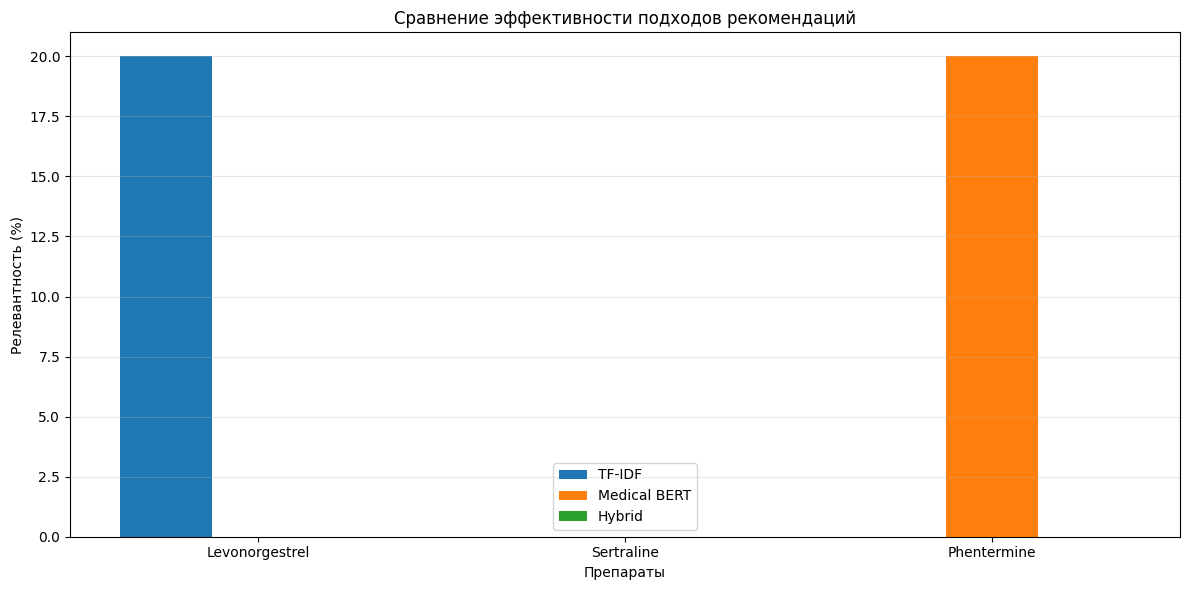

In [89]:
def plot_performance_comparison(performance_results):
    """
    Визуализация сравнения подходов
    """
    if not performance_results:
        return
    
    # данные для графика
    approaches = ["TF-IDF", "Medical BERT", "Hybrid"]
    drugs = [result['drug'] for result in performance_results]
    
    # матрица релевантности
    relevance_matrix = []
    for approach in approaches:
        approach_scores = []
        for result in performance_results:
            for approach_data in result['approaches']:
                if approach_data['approach'] == approach:
                    approach_scores.append(approach_data['relevance_pct'])
                    break
        relevance_matrix.append(approach_scores)
    
    fig, ax = plt.subplots(figsize=(12, 6))
    
    x = np.arange(len(drugs))
    width = 0.25
    
    for i, (approach, scores) in enumerate(zip(approaches, relevance_matrix)):
        ax.bar(x + i*width, scores, width, label=approach)
    
    ax.set_xlabel('Препараты')
    ax.set_ylabel('Релевантность (%)')
    ax.set_title('Сравнение эффективности подходов рекомендаций')
    ax.set_xticks(x + width)
    ax.set_xticklabels(drugs)
    ax.legend()
    ax.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.show()

if performance_results:
    plot_performance_comparison(performance_results)

### **ФИНАЛЬНАЯ СИСТЕМА ДЛЯ ИНФЕРЕНСА**

In [90]:
class ColdStartRecommender:
    def __init__(self, medical_bert, tfidf_vectorizer, train_medical_bert, train_drugs):
        self.medical_bert = medical_bert
        self.tfidf_vectorizer = tfidf_vectorizer
        self.train_medical_bert = train_medical_bert
        self.train_drugs = train_drugs
        
    def recommend_for_new_drug(self, new_drug_reviews, top_n=5):
        """
        Рекомендации для нового препарата на основе его отзывов
        """
        if not new_drug_reviews:
            return []
            
        # векторизуем отзывы нового препарата с Medical BERT
        combined_review = ' '.join(new_drug_reviews)
        new_drug_vector = self.medical_bert.encode([combined_review])
        
        # ищем похожие препараты в train данных
        similarities = cosine_similarity(new_drug_vector, self.train_medical_bert).flatten()
        
        # Топ-N самых похожих препаратов
        similar_indices = similarities.argsort()[::-1][:top_n]
        
        recommendations = []
        for idx in similar_indices:
            if idx < len(self.train_drugs):
                recommendations.append({
                    'drug': self.train_drugs[idx],
                    'similarity': similarities[idx],
                    'method': 'cold_start_medical_bert'
                })
        
        return recommendations

print("СОЗДАНИЕ COLD-START РЕКОМЕНДАТОРА...")
cold_start_recommender = ColdStartRecommender(
    medical_bert=bert_model,
    tfidf_vectorizer=tfidf_vectorizer,
    train_medical_bert=train_bert,
    train_drugs=train_drug_names
)

СОЗДАНИЕ COLD-START РЕКОМЕНДАТОРА...


In [91]:
class ProductionRecommender:
    def __init__(self, hybrid_recommender, content_recommender):
        self.hybrid_recommender = hybrid_recommender
        self.content_recommender = content_recommender
        
    def recommend(self, target_drug, top_n=5):
        """
        Финальная система рекомендаций
        """
        try:
            # гибридный подход
            recommendations = self.hybrid_recommender.hybrid_recommend(target_drug, top_n)
            if recommendations:
                return recommendations
        except Exception as e:
            print(f"Гибридный подход не сработал: {e}")
        
        # Fallback на Medical BERT
        try:
            return self.content_recommender.recommend_similar_drugs(target_drug, top_n, method='bert')
        except Exception as e:
            print(f"BERT подход не сработал: {e}")
            return []
    
    def explain_recommendation(self, target_drug, recommended_drug):
        """
        Объяснение рекомендации
        """
        target_data = train_data_raw[train_data_raw['drugName'] == target_drug]
        rec_data = train_data_raw[train_data_raw['drugName'] == recommended_drug]
        
        if len(target_data) == 0 or len(rec_data) == 0:
            return ["Недостаточно данных для объяснения"]
        
        target_category = target_data['condition_category'].iloc[0]
        rec_category = rec_data['condition_category'].iloc[0]
        
        explanations = []
        
        # релевантность
        if target_category == rec_category:
            explanations.append(f"Оба препарата относятся к категории '{target_category}'")
        else:
            explanations.append(f"Разные категории: '{target_category}' → '{rec_category}'")
        
        # дополнительная информация
        target_rating = target_data['rating'].mean()
        rec_rating = rec_data['rating'].mean()
        explanations.append(f"Средние оценки: {target_drug} - {target_rating:.1f}/10, {recommended_drug} - {rec_rating:.1f}/10")
        
        # анализ побочных эффектов
        target_side_effects = target_data['has_side_effects'].mean()
        rec_side_effects = rec_data['has_side_effects'].mean()
        explanations.append(f"Частота упоминания побочных эффектов: {target_drug} - {target_side_effects:.1%}, {recommended_drug} - {rec_side_effects:.1%}")
        
        return explanations


production_recommender = ProductionRecommender(
    hybrid_recommender=hybrid_recommender,
    content_recommender=recommender
)

print("ЗАПУСК ДЕМОНСТРАЦИИ...")

ЗАПУСК ДЕМОНСТРАЦИИ...


In [92]:
def demonstrate_inference():
    """
    Демонстрация работы финальной системы
    """
    print(" ДЕМОНСТРАЦИЯ РАБОТЫ СИСТЕМЫ РЕКОМЕНДАЦИЙ")
    
    test_cases = [
        ('Levonorgestrel', 'Гинекология'),
        ('Sertraline', 'Психиатрия'), 
        ('Phentermine', 'Другое')
    ]
    
    for target_drug, expected_category in test_cases:
        if target_drug not in drug_to_index_map:
            print(f" Пропускаем {target_drug} - нет в обучающих данных")
            continue
            
        print(f"\n ЗАПРОС: Рекомендации для {target_drug} ({expected_category})")
        print("-" * 50)
        
        try:
            recommendations = production_recommender.recommend(target_drug)
        except Exception as e:
            print(f" Ошибка при получении рекомендаций: {e}")
            continue
        
        if not recommendations:
            print(" Нет рекомендаций")
            continue
            
        relevant_count = 0
        
        for i, rec in enumerate(recommendations, 1):
            # получение категории рекомендованного препарата
            rec_drug_data = train_data_raw[train_data_raw['drugName'] == rec['drug']]
            if len(rec_drug_data) == 0:
                rec_category = "Неизвестно"
            else:
                rec_category = rec_drug_data['condition_category'].iloc[0]
            
            # релевантность
            is_relevant = (rec_category == expected_category)
            if is_relevant:
                relevant_count += 1
                
            # индикатор релевантности
            relevance_indicator = "✓" if is_relevant else "✕"
            
           
            if 'hybrid_score' in rec:
                print(f"{relevance_indicator} {i}. {rec['drug']} ({rec_category})")
                print(f"   Hybrid score: {rec['hybrid_score']:.3f} | "
                      f"Content: {rec['content_score']:.3f} | "
                      f"Medical: {rec.get('medical_score', 0):.3f}")  
            else:
                print(f"{relevance_indicator} {i}. {rec['drug']} ({rec_category})")
                print(f"   Similarity: {rec['similarity']:.3f}")
            
            # объяснение для релевантных рекомендаций
            if is_relevant:
                try:
                    explanations = production_recommender.explain_recommendation(target_drug, rec['drug'])
                    for explanation in explanations:
                        print(f"   → {explanation}")
                except Exception as e:
                    print(f"   → Не удалось сгенерировать объяснение: {e}")
        
        # статистика по запросу
        print(f"\n Релевантных рекомендаций: {relevant_count}/{len(recommendations)} ({relevant_count/len(recommendations)*100:.1f}%)")
demonstrate_inference()

 ДЕМОНСТРАЦИЯ РАБОТЫ СИСТЕМЫ РЕКОМЕНДАЦИЙ

 ЗАПРОС: Рекомендации для Levonorgestrel (Гинекология)
--------------------------------------------------
✕ 1. Hiprex (Дерматология)
   Hybrid score: 0.779 | Content: 0.774 | Medical: 0.784
✕ 2. Dalmane (Психиатрия)
   Hybrid score: 0.770 | Content: 0.798 | Medical: 0.743
✕ 3. Xolair (Другое)
   Hybrid score: 0.741 | Content: 0.788 | Medical: 0.694
✕ 4. Cleocin (Дерматология)
   Hybrid score: 0.727 | Content: 0.800 | Medical: 0.654
✕ 5. Xylometazoline (Другое)
   Hybrid score: 0.722 | Content: 0.804 | Medical: 0.392

 Релевантных рекомендаций: 0/5 (0.0%)

 ЗАПРОС: Рекомендации для Sertraline (Психиатрия)
--------------------------------------------------
✕ 1. Zyloprim (Другое)
   Hybrid score: 0.820 | Content: 0.806 | Medical: 0.877
✕ 2. Calamine (Дерматология)
   Hybrid score: 0.765 | Content: 0.758 | Medical: 0.772
✕ 3. Requip XL (Неврология)
   Hybrid score: 0.753 | Content: 0.772 | Medical: 0.735
✕ 4. Compro (Другое)
   Hybrid score: 0.736

In [93]:

def test_cold_start():
    """
    Тестирование на препаратах из test set (новые препараты)
    """
    print("\n ТЕСТИРОВАНИЕ COLD-START СЦЕНАРИЯ")
    
    # берем препараты из test set
    cold_start_drugs = test_data_raw['drugName'].value_counts().index[:2]
    
    for new_drug in cold_start_drugs:
        print(f"\n НОВЫЙ ПРЕПАРАТ: {new_drug}")
        
        # отзывы о новом препарате
        new_drug_reviews = test_data_raw[test_data_raw['drugName'] == new_drug]['cleaned_review'].tolist()
        
        if new_drug_reviews:
            # Cold-start рекомендации
            cold_start_recs = cold_start_recommender.recommend_for_new_drug(new_drug_reviews, top_n=3)
            
            if cold_start_recs:
                print("Рекомендуемые похожие препараты:")
                for i, rec in enumerate(cold_start_recs, 1):
                    rec_category = train_data_raw[train_data_raw['drugName'] == rec['drug']]['condition_category'].iloc[0]
                    print(f"  {i}. {rec['drug']} ({rec_category}) - схожесть: {rec['similarity']:.3f}")
            else:
                print("  Нет рекомендаций")
        else:
            print("  Нет отзывов для анализа")

test_cold_start()


 ТЕСТИРОВАНИЕ COLD-START СЦЕНАРИЯ

 НОВЫЙ ПРЕПАРАТ: Ethinyl estradiol / levonorgestrel
Рекомендуемые похожие препараты:
  1. Trazodone (Другое) - схожесть: 0.894
  2. Ruconest (Другое) - схожесть: 0.890
  3. Orencia (Обезболивание) - схожесть: 0.879

 НОВЫЙ ПРЕПАРАТ: Bupropion / naltrexone
Рекомендуемые похожие препараты:
  1. Xifaxan (Другое) - схожесть: 0.877
  2. Cosentyx (Дерматология) - схожесть: 0.875
  3. Ryzolt (Обезболивание) - схожесть: 0.854
